In [1]:
import warnings

import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.stattools import kpss

pd.plotting.register_matplotlib_converters()

warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 3.1.1. Seasonality analysis

The seasonality patterns can be explored in detail by using boxplots. Seasonality is clearly confirmed for the categories of R03, R06 and N02BE. Some additional conclusions: R03 and N05C has more outliers that the others, indicating that their sales is more difficult to predict.

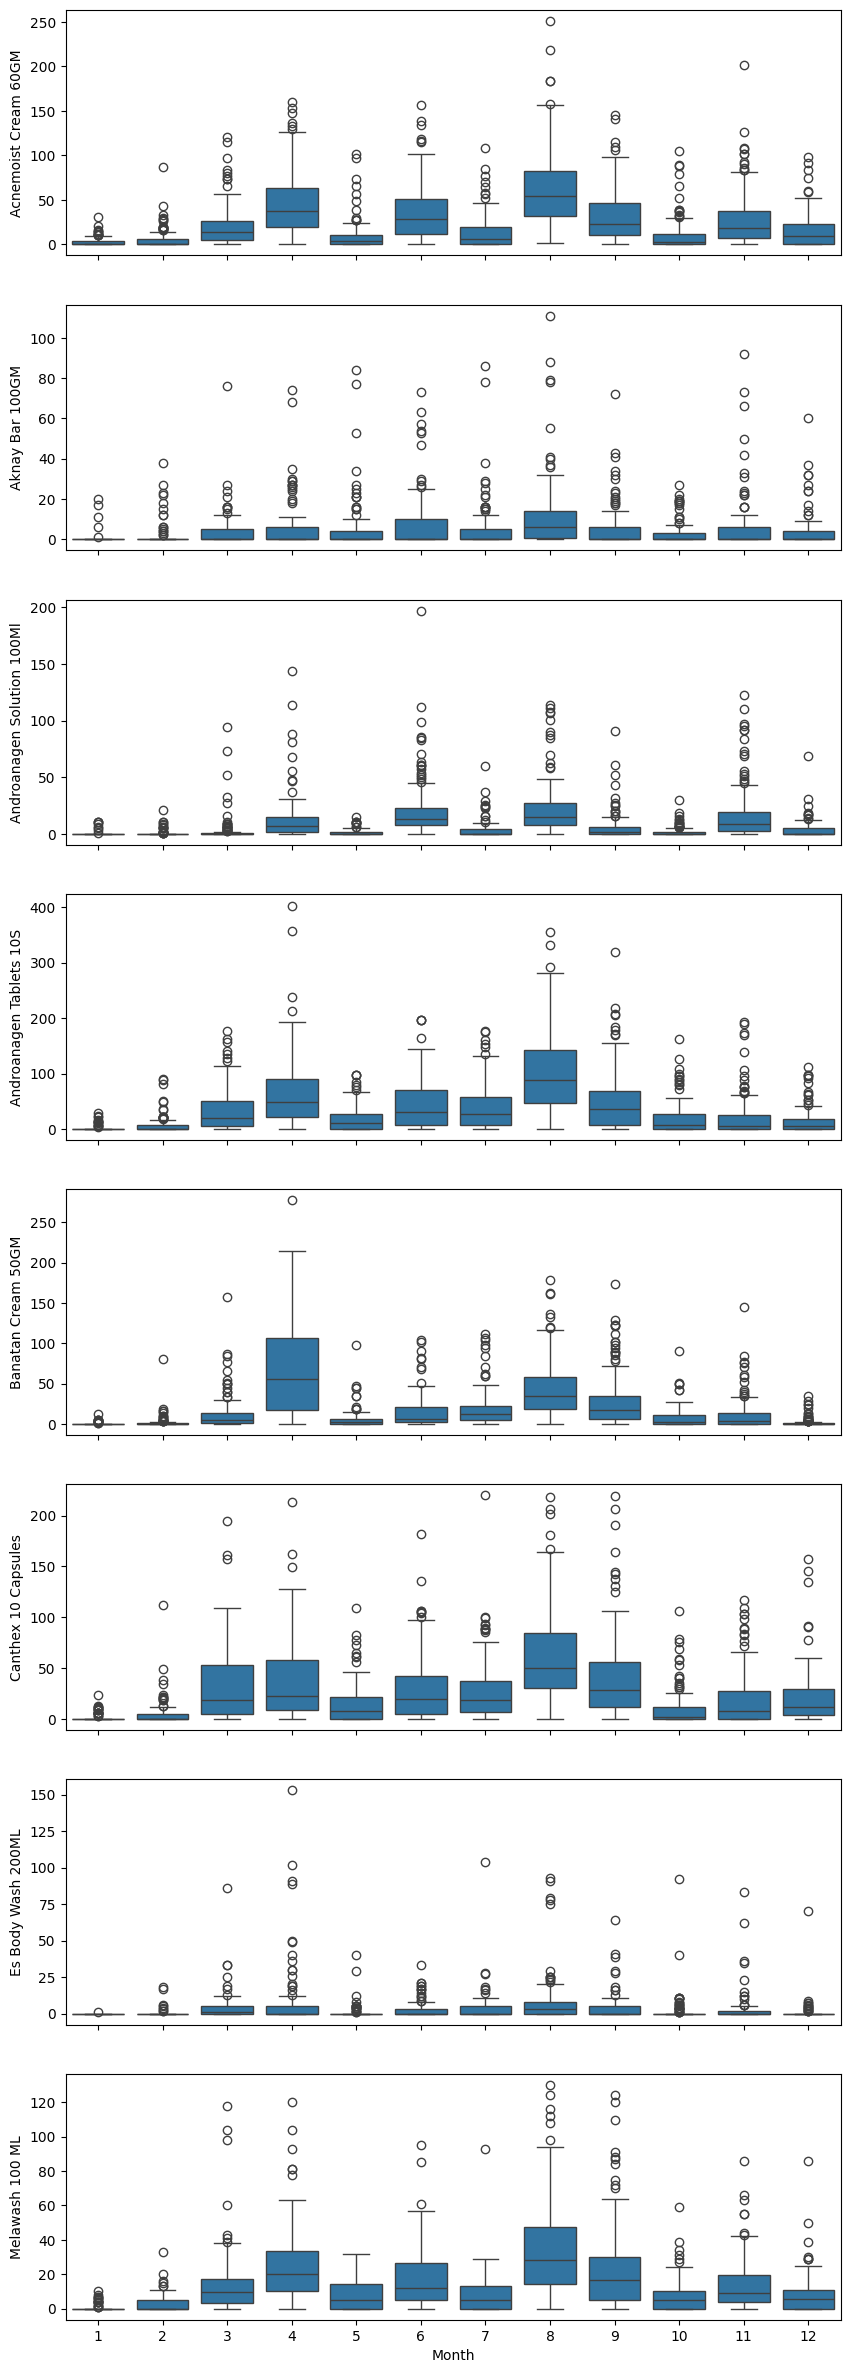

In [2]:
import seaborn as sns
dfatc_daily = pd.read_csv('salesdaily.csv',encoding='latin1')
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['Acnemoist Cream 60GM','Aknay Bar 100GM','Androanagen Solution 100Ml','Androanagen Tablets 10S', 'Banatan Cream 50GM','Canthex 10 Capsules','Es Body Wash 200ML','Melawash 100 ML',"Nixiyax 15 'S",'Triobloc Cream 25GM','Zinikam Cream 200 G'], axes):
    sns.boxplot(data=dfatc_daily, x='Month', y=name, ax=ax)

Below, boxplots on a weekly scale are shown, for the purpose of exploring the weakly seasonality. Some weekly seasonality is visible.

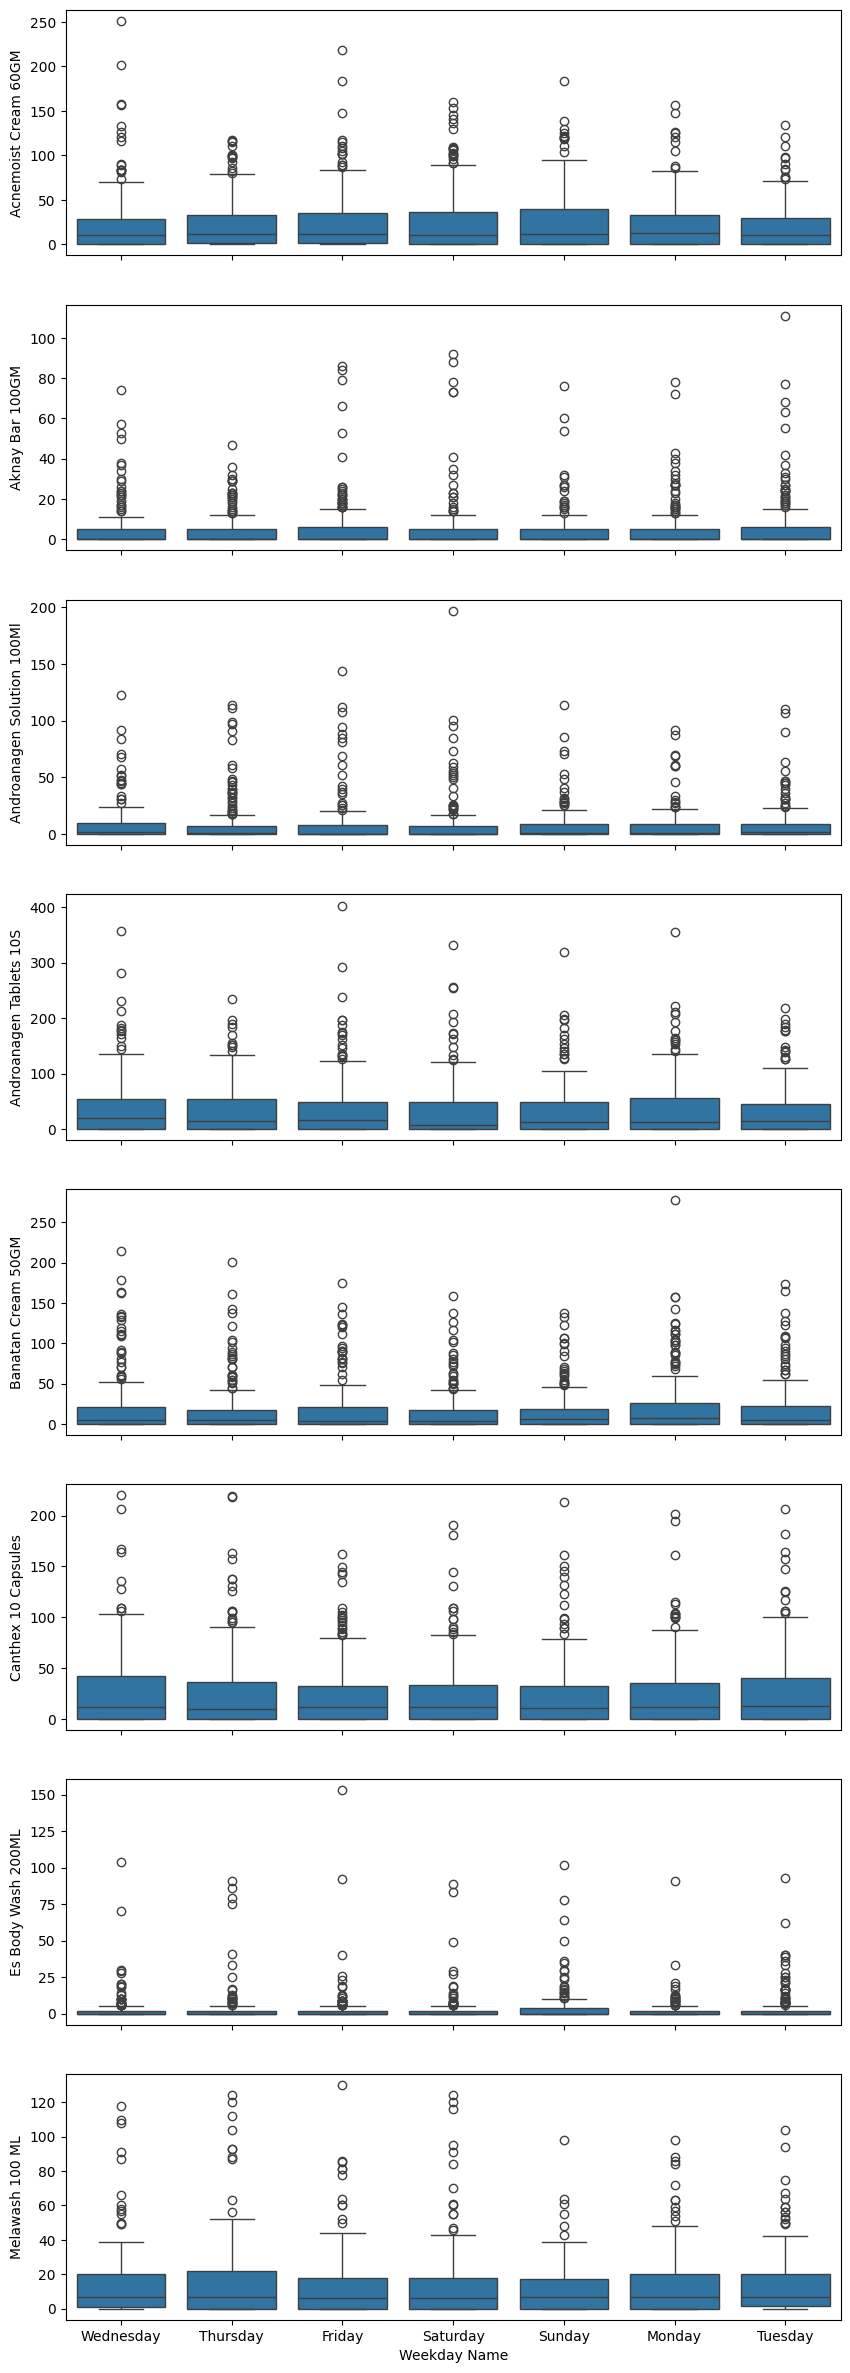

In [3]:
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['Acnemoist Cream 60GM','Aknay Bar 100GM','Androanagen Solution 100Ml','Androanagen Tablets 10S', 'Banatan Cream 50GM','Canthex 10 Capsules','Es Body Wash 200ML','Melawash 100 ML',"Nixiyax 15 'S",'Triobloc Cream 25GM','Zinikam Cream 200 G'], axes):
    sns.boxplot(data=dfatc_daily, x='Weekday Name', y=name, ax=ax)

Another visualization that can be useful for discovering seasonality patterns is related to rolling window means. Analysis below shows 30-day and 365-day rolling mean and 30-day rolling standard deviation of sales data.

In [4]:
dfatc_daily.head()

datum  Acnemoist Cream 60GM  Aknay Bar 100GM  \
0  2020-01-01                   7.0              0.0   
1  2020-01-02                   7.0              0.0   
2  2020-01-03                   0.0              0.0   
3  2020-01-04                   0.0              0.0   
4  2020-01-05                   0.0              0.0   

   Androanagen Solution 100Ml  Androanagen Tablets 10S  Banatan Cream 50GM  \
0                         0.0                     12.0                 0.0   
1                         0.0                      0.0                 0.0   
2                         0.0                      0.0                 0.0   
3                         1.0                      0.0                 0.0   
4                         0.0                      0.0                 0.0   

   Canthex 10 Capsules  Es Body Wash 200ML  Melawash 100 ML  Nixiyax 15 'S  \
0                  0.0                 0.0              0.0            0.0   
1                  9.0                 0.0              0.0            0.0   
2                  0.0                 0.0              0.0            0.0   
3                  0.0                 0.0              0.0            0.0   
4                  0.0                 0.0              0.0            0.0   

   Triobloc Cream 25GM  Zinikam Cream 200 G  Month  Year Weekday Name  Hour  \
0                  0.0                  4.0      1  2020    Wednesday     0   
1                  0.0                  0.0      1  2020     Thursday     0   
2                  0.0                  0.0      1  2020       Friday     0   
3                  0.0                  0.0      1  2020     Saturday     0   
4                  0.0                  0.0      1  2020       Sunday     0   

   Hours  
0    276  
1    276  
2    276  
3    276  
4    276

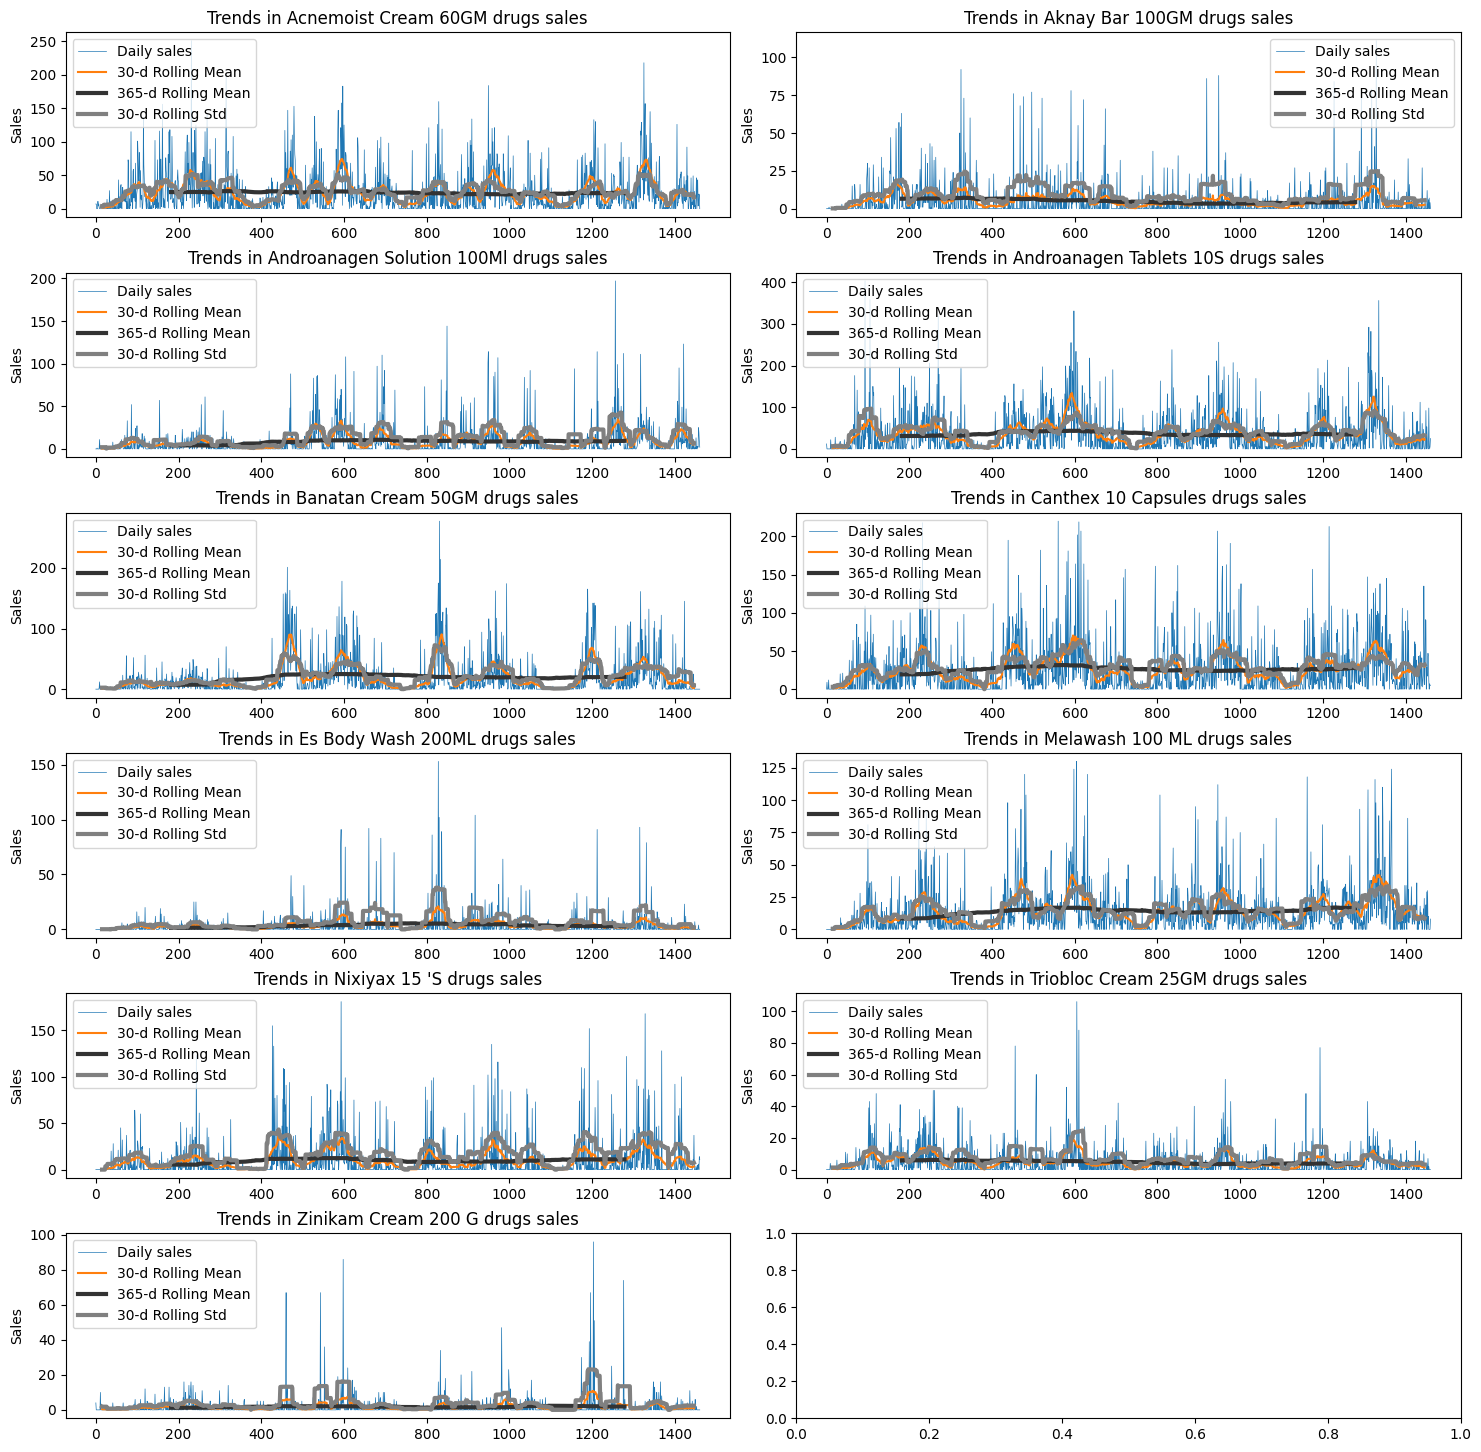

In [4]:
dfatc_daily=pd.read_csv('salesdaily.csv')
cols_plot = ['Acnemoist Cream 60GM','Aknay Bar 100GM','Androanagen Solution 100Ml','Androanagen Tablets 10S', 'Banatan Cream 50GM','Canthex 10 Capsules','Es Body Wash 200ML','Melawash 100 ML',"Nixiyax 15 'S",'Triobloc Cream 25GM','Zinikam Cream 200 G']
dfatc_365d = dfatc_daily[cols_plot].rolling(window=365, center=True).mean()
dfatc_30d = dfatc_daily[cols_plot].rolling(30, center=True).mean()
dfatc_std = dfatc_daily[cols_plot].rolling(30, center=True).std()
subplotindex=0
numrows=6
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18, 18))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for x in cols_plot:
    # rowindex = subplotindex // numcols  # Use integer division to get the row index
    # colindex = subplotindex % numcols   # Use modulo to get the column index
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ax[rowindex,colindex].plot(dfatc_daily.loc[:,x], linewidth=0.5, label='Daily sales')
    ax[rowindex,colindex].plot(dfatc_30d.loc[:,x], label='30-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_365d.loc[:,x], color='0.2', linewidth=3, label='365-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_std.loc[:,x], color='0.5', linewidth=3, label='30-d Rolling Std')
    ax[rowindex,colindex].set_ylabel('Sales')
    ax[rowindex,colindex].legend()
    ax[rowindex,colindex].set_title('Trends in '+x+' drugs sales');
    subplotindex=subplotindex+1
plt.show()

Image below shows trends for each of the drug categories, represented by the 365-d rolling means for each of those categories.

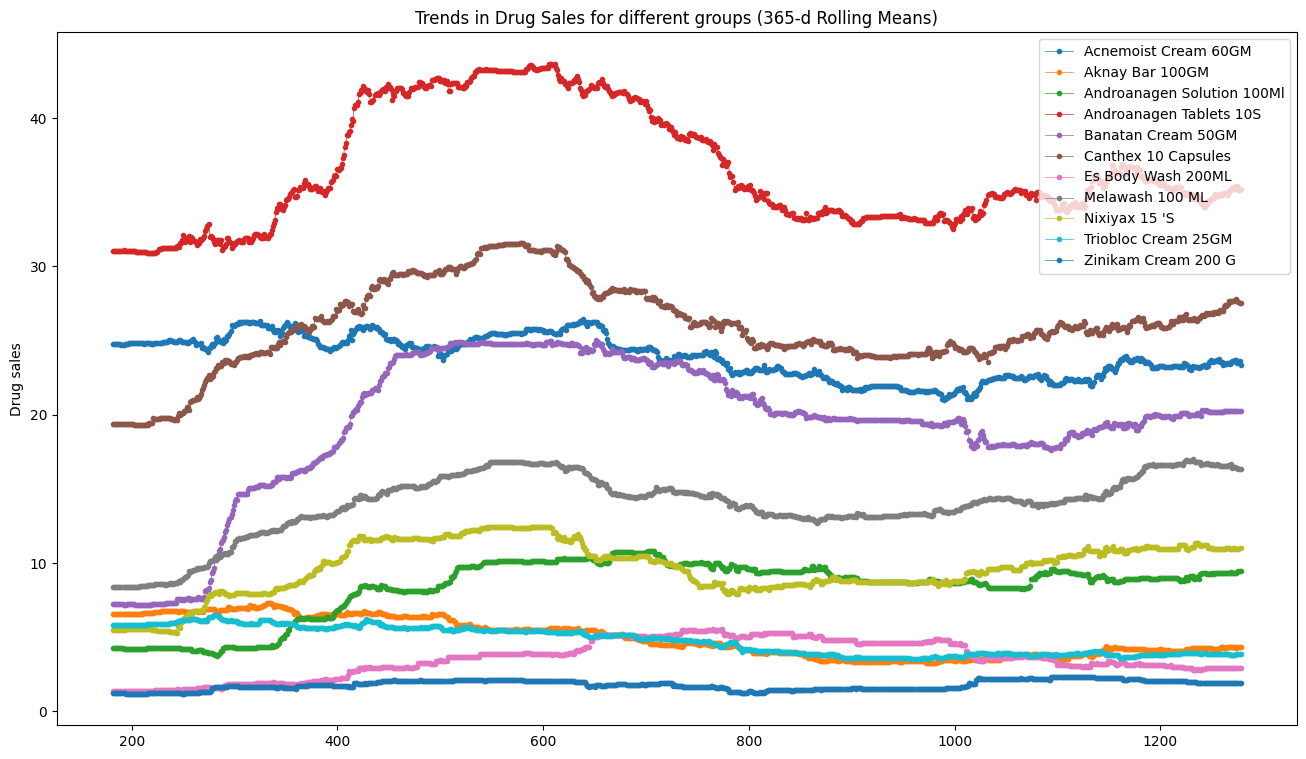

In [5]:
fig, ax = plt.subplots(figsize=(16,9))
for nm in cols_plot:
    ax.plot(dfatc_365d[nm], label=nm, marker='.', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.set_ylabel('Drug sales')
    ax.set_title('Trends in Drug Sales for different groups (365-d Rolling Means)');

Trends and seasonality can be explored in time series decomposition view, based on 30d rolling means.

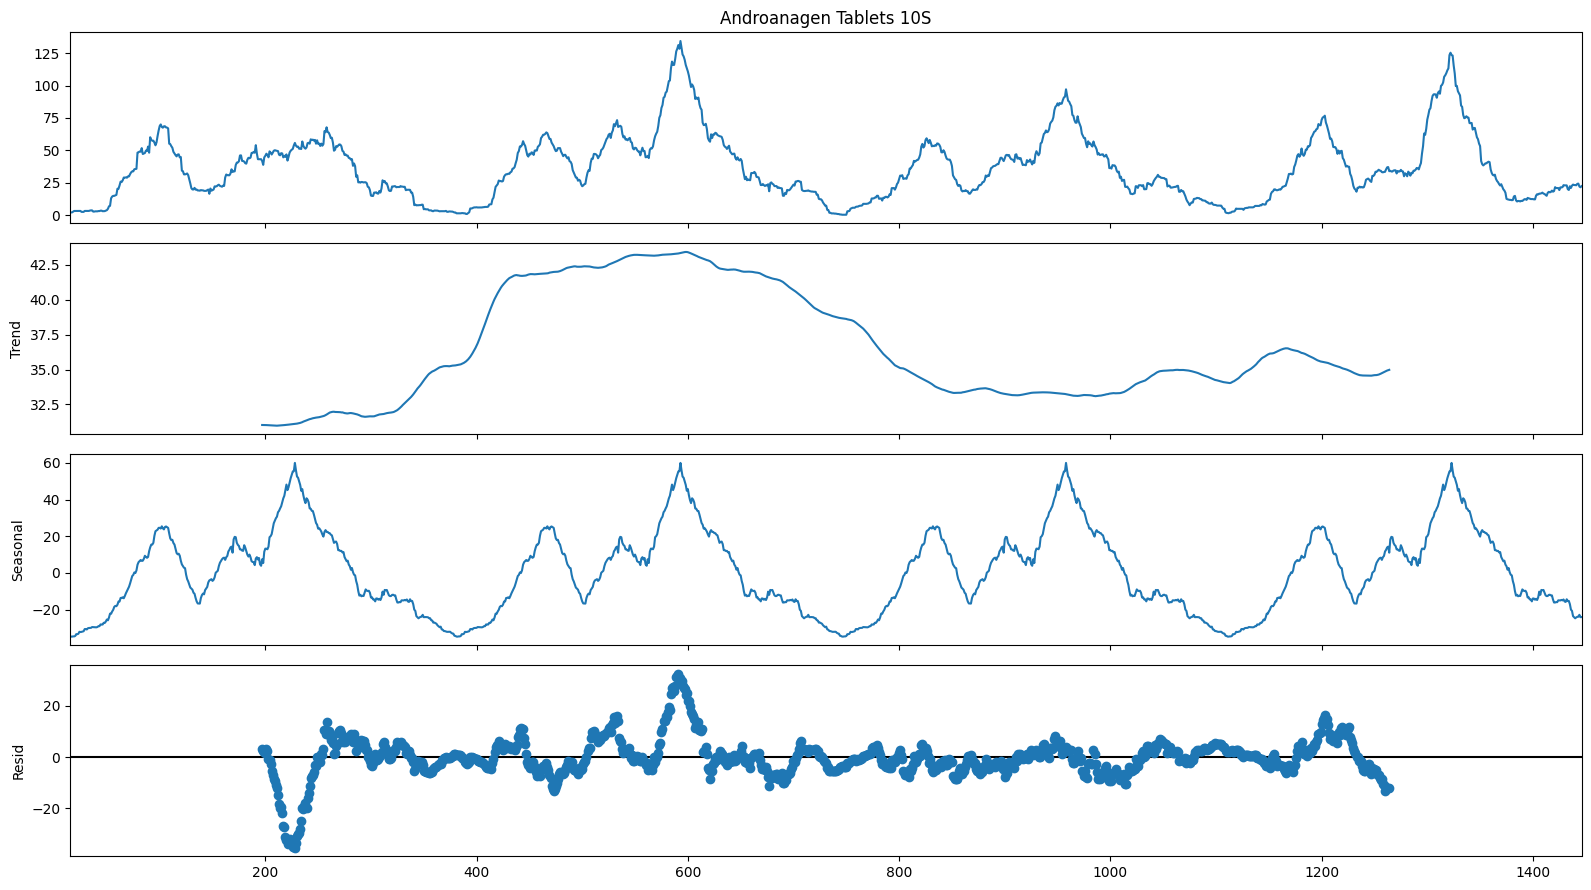

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(dfatc_daily['Androanagen Tablets 10S'].rolling(30, center=True).mean().dropna(), period=365, filt=None)
plt.rcParams["figure.figsize"] = (16,9)
result.plot()
plt.show()

Function seasonal_decompose can be used for analysis of the portions of each component of time series. This is especially useful when determining uptake of residuals in data, based on the decomposed data. The volume of this uptake implies the predictability of the time series - higher the residuals, lower the predictability. To some extent, the proportion of the residuals when comparing with trend and seasonality can be also illustrated by the rolling means and standard deviation plots above.

In [7]:
df = pd.read_csv('salesweekly.csv')
for x in ['Acnemoist Cream 60GM','Aknay Bar 100GM','Androanagen Solution 100Ml','Androanagen Tablets 10S', 'Banatan Cream 50GM','Canthex 10 Capsules','Es Body Wash 200ML','Melawash 100 ML',"Nixiyax 15 'S",'Triobloc Cream 25GM','Zinikam Cream 200 G']:
    result = seasonal_decompose(df[x], period=52, model='additive')
    dfs = pd.concat([result.trend, result.seasonal, result.resid, result.observed], axis=1)
    dfs.columns = ['trend', 'seasonal', 'residuals', 'observed']
    dfs=dfs.dropna()
    res=dfs['residuals'].values
    obs=dfs['observed'].values
    resmean=np.mean(np.abs(res))
    obsmean=np.mean(np.abs(obs))
    perc=resmean*100/obsmean
    print(x+' RESMEAN:'+str(resmean)+', OBSMEAN:'+str(obsmean)+', PERC:'+str(perc)+'%')

Acnemoist Cream 60GM RESMEAN:39.44949754001307, OBSMEAN:167.13375796178343, PERC:23.60354845191331%
Aknay Bar 100GM RESMEAN:16.959453302648278, OBSMEAN:34.197452229299365, PERC:49.59273921616278%
Androanagen Solution 100Ml RESMEAN:28.132825062971897, OBSMEAN:59.738853503184714, PERC:47.09301135394592%
Androanagen Tablets 10S RESMEAN:73.5658756116597, OBSMEAN:253.21019108280254, PERC:29.05328387339783%
Banatan Cream 50GM RESMEAN:41.3481835513009, OBSMEAN:134.21656050955414, PERC:30.807065383230075%
Canthex 10 Capsules RESMEAN:49.06611018590058, OBSMEAN:182.9936305732484, PERC:26.813015312169828%
Es Body Wash 200ML RESMEAN:16.73862462154047, OBSMEAN:24.67515923566879, PERC:67.83593354625333%
Melawash 100 ML RESMEAN:26.729139774054953, OBSMEAN:97.6624203821656, PERC:27.368909831909132%
Nixiyax 15 'S RESMEAN:32.3944431619744, OBSMEAN:66.8343949044586, PERC:48.46971863556638%
Triobloc Cream 25GM RESMEAN:14.086731028342065, OBSMEAN:33.49044585987261, PERC:42.06193935811534%
Zinikam Cream 200

### 4.2.2. Stationarity analysis

Stationarity of time-series is the property of exhibiting constant statistical properties over time (for example, mean, variance, autocorrelation). It can be visually determined by plotting rolling statistics (rolling means and variances). In stationary time series, the mean of the series, variance of the series and covariance of the i th term and the (i + m) th term should not be a function of time.

We can use Augmented Dickey-Fuller (ADF) test to check stationarity of the data. Possible values of regression parameters of ADF are:
- c : constant only (default)
- ct : constant and trend
- ctt : constant, and linear and quadratic trend
- nc : no constant, no trend

In [8]:
df = pd.read_csv('salesweekly.csv')
from statsmodels.tsa.stattools import adfuller

for x in ['Acnemoist Cream 60GM','Aknay Bar 100GM','Androanagen Solution 100Ml','Androanagen Tablets 10S', 'Banatan Cream 50GM','Canthex 10 Capsules','Es Body Wash 200ML','Melawash 100 ML',"Nixiyax 15 'S",'Triobloc Cream 25GM','Zinikam Cream 200 G']:
    dftest = adfuller(df[x], regression='ct', autolag='AIC')
    print("ADF test for "+x)
    print("-----------------------------")
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

ADF test for Acnemoist Cream 60GM
-----------------------------
Test statistic = -7.254
P-value = 0.000
Critical values :
	1%: -4.0036234899377545 - The data is  stationary with 99% confidence
	5%: -3.4321268670216623 - The data is  stationary with 95% confidence
	10%: -3.139758677471308 - The data is  stationary with 90% confidence
ADF test for Aknay Bar 100GM
-----------------------------
Test statistic = -5.521
P-value = 0.000
Critical values :
	1%: -4.003402336644926 - The data is  stationary with 99% confidence
	5%: -3.4320207442298027 - The data is  stationary with 95% confidence
	10%: -3.1396965086430555 - The data is  stationary with 90% confidence
ADF test for Androanagen Solution 100Ml
-----------------------------
Test statistic = -7.550
P-value = 0.000
Critical values :
	1%: -4.0036234899377545 - The data is  stationary with 99% confidence
	5%: -3.4321268670216623 - The data is  stationary with 95% confidence
	10%: -3.139758677471308 - The data is  stationary with 90% confi

In [9]:
# Assuming df is your DataFrame
df = pd.read_csv('salesweekly.csv')

for x in ['Acnemoist Cream 60GM','Aknay Bar 100GM','Androanagen Solution 100Ml','Androanagen Tablets 10S', 'Banatan Cream 50GM','Canthex 10 Capsules','Es Body Wash 200ML','Melawash 100 ML',"Nixiyax 15 'S",'Triobloc Cream 25GM','Zinikam Cream 200 G']:
    print(" > Is "+x+" data stationary ?")

    # Remove zeros if they are present
    non_zero_data = df[x][df[x] != 0]

    # Check for constant values
    if non_zero_data.nunique() == 1:
        print(f"The {x} data is constant. Consider differencing.")
    else:
        # Perform the KPSS test
        dftest = kpss(np.log(non_zero_data), 'ct')
        print("Test statistic = {:.3f}".format(dftest[0]))
        print("P-value = {:.3f}".format(dftest[1]))
        print("Critical values :")
        for k, v in dftest[3].items():
            print("\t{}: {}".format(k, v))

 > Is Acnemoist Cream 60GM data stationary ?
Test statistic = 0.037
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is Aknay Bar 100GM data stationary ?
Test statistic = 0.077
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is Androanagen Solution 100Ml data stationary ?
Test statistic = 0.053
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is Androanagen Tablets 10S data stationary ?
Test statistic = 0.051
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is Banatan Cream 50GM data stationary ?
Test statistic = 0.080
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is Canthex 10 Capsules data stationary ?
Test statistic = 0.070
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is Es Body Wash 200ML data stationary ?
Test statistic = 0.216
P-value = 0.010
Critical values :
	10%:

### 4.2.3. Regularity analysis

For calculating regularity and predictability of time series, Approximate Entropy test was used. For all series, entropy values were higher than 1 indicating low predictability, with highest values.

In [10]:
df = pd.read_csv('salesweekly.csv')
def ApEn(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))
    N = len(U)
    return abs(_phi(m+1) - _phi(m))

for x in ['Acnemoist Cream 60GM','Aknay Bar 100GM','Androanagen Solution 100Ml','Androanagen Tablets 10S', 'Banatan Cream 50GM','Canthex 10 Capsules','Es Body Wash 200ML','Melawash 100 ML',"Nixiyax 15 'S",'Triobloc Cream 25GM','Zinikam Cream 200 G']:
    print(x + ': ' + str(ApEn(df[x].values, m=2, r=0.2*np.std(df[x].values))))

Acnemoist Cream 60GM: 1.0119833039156365
Aknay Bar 100GM: 1.0131535371816205
Androanagen Solution 100Ml: 0.8216221326910929
Androanagen Tablets 10S: 0.8691601620226868
Banatan Cream 50GM: 0.8318855685986235
Canthex 10 Capsules: 0.9356169689146645
Es Body Wash 200ML: 0.9534694430580055
Melawash 100 ML: 0.9587752354794534
Nixiyax 15 'S: 0.8633154607068412
Triobloc Cream 25GM: 0.9749537571570484
Zinikam Cream 200 G: 0.8819276494110975


### 4.2.4. Autocorrelation analysis

Autocorrelation analysis illustrates the potential for time series data prediction. Autocorrelation plots graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. Pearson coefficient is used to measure autocorrelation. Thus, the following analysis is relevant only for data with normal Gaussian distribution.

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function (ACF). This plot is sometimes called a correlogram or an autocorrelation plot. Plot shows the lag value along the x-axis and the correlation on the y-axis between -1 and 1. Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation.

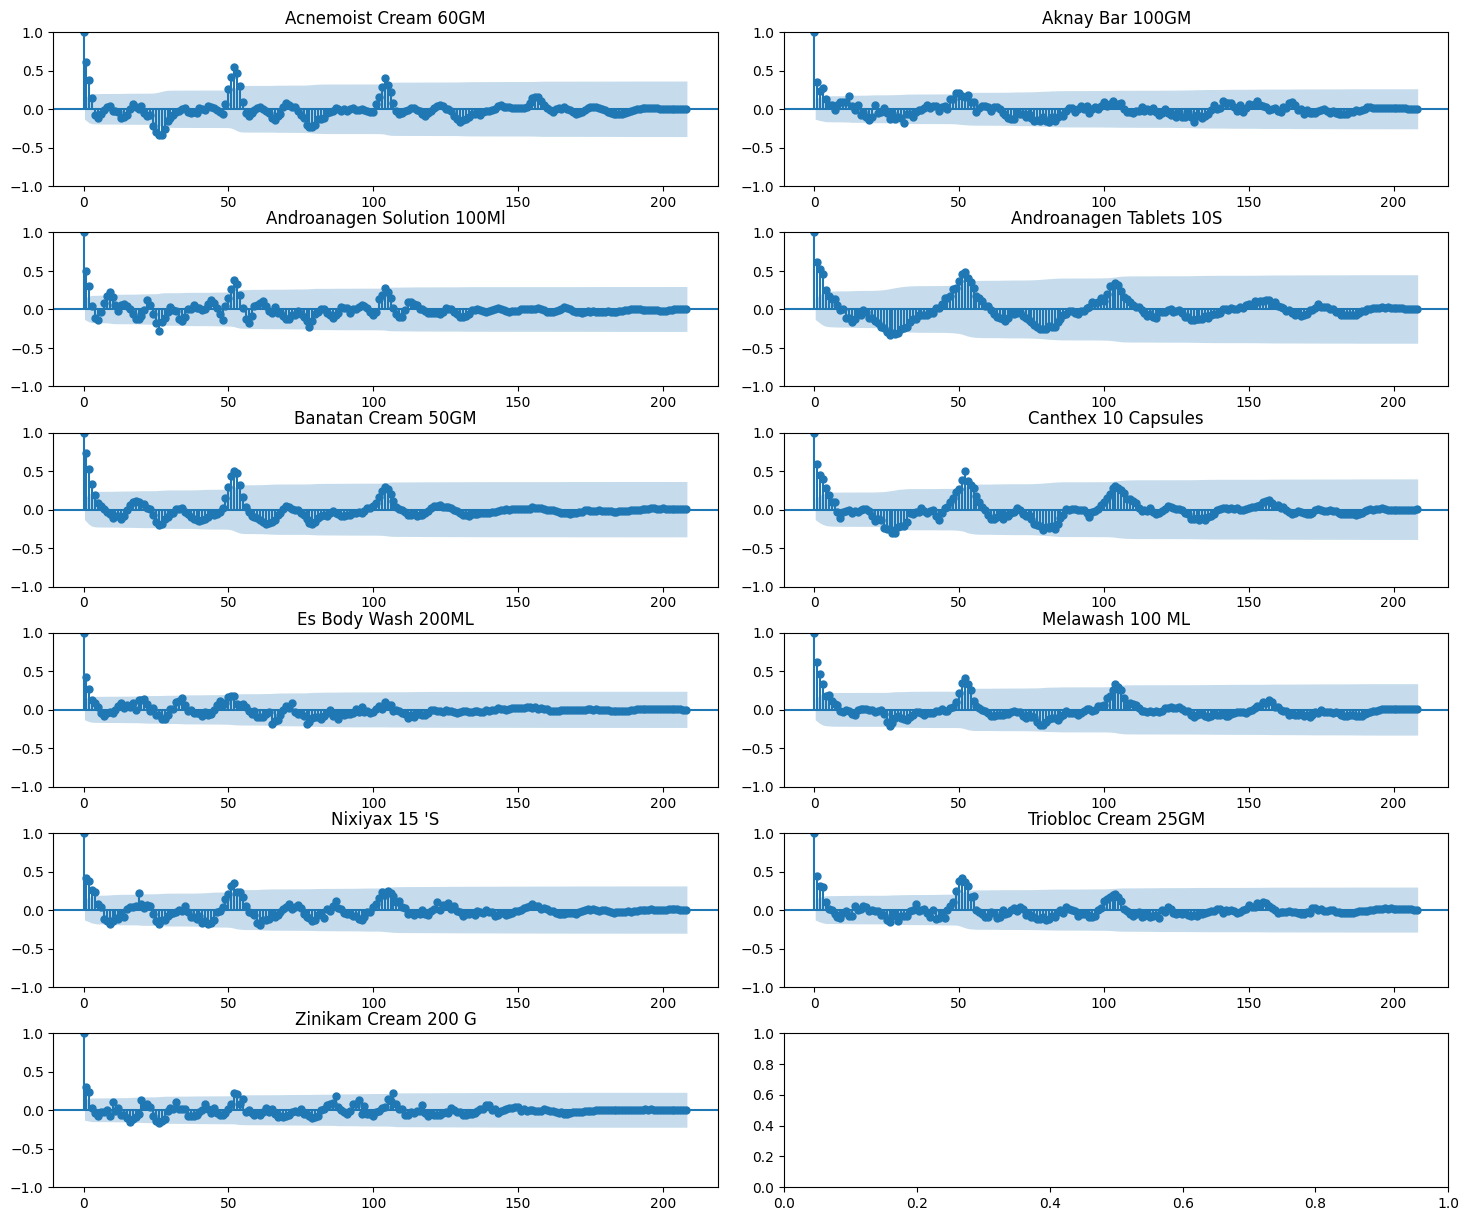

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
import math

df = pd.read_csv('salesweekly.csv')

subplotindex = 0
numrows = 6
numcols = 2
fig, ax = plt.subplots(numrows, numcols, figsize=(18, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

with plt.rc_context():
    plt.rc("figure", figsize=(18, 12))
    for x in ['Acnemoist Cream 60GM','Aknay Bar 100GM','Androanagen Solution 100Ml','Androanagen Tablets 10S', 'Banatan Cream 50GM','Canthex 10 Capsules','Es Body Wash 200ML','Melawash 100 ML',"Nixiyax 15 'S",'Triobloc Cream 25GM','Zinikam Cream 200 G']:
        rowindex = math.floor(subplotindex / numcols)
        colindex = subplotindex - (rowindex * numcols)

        # Adjust the number of lags dynamically
        max_lags = len(df[x]) - 1
        lags = min(300, max_lags)

        plot_acf(df[x], lags=lags, title=x, ax=ax[rowindex, colindex])
        subplotindex += 1

plt.show()


In general, the "partial" correlation between two variables is the amount of correlation between them which is not explained by their mutual correlations with a specified set of other variables. For example, if we are regressing a variable Y on other variables X1, X2, and X3, the partial correlation between Y and X3 is the amount of correlation between Y and X3 that is not explained by their common correlations with X1 and X2.

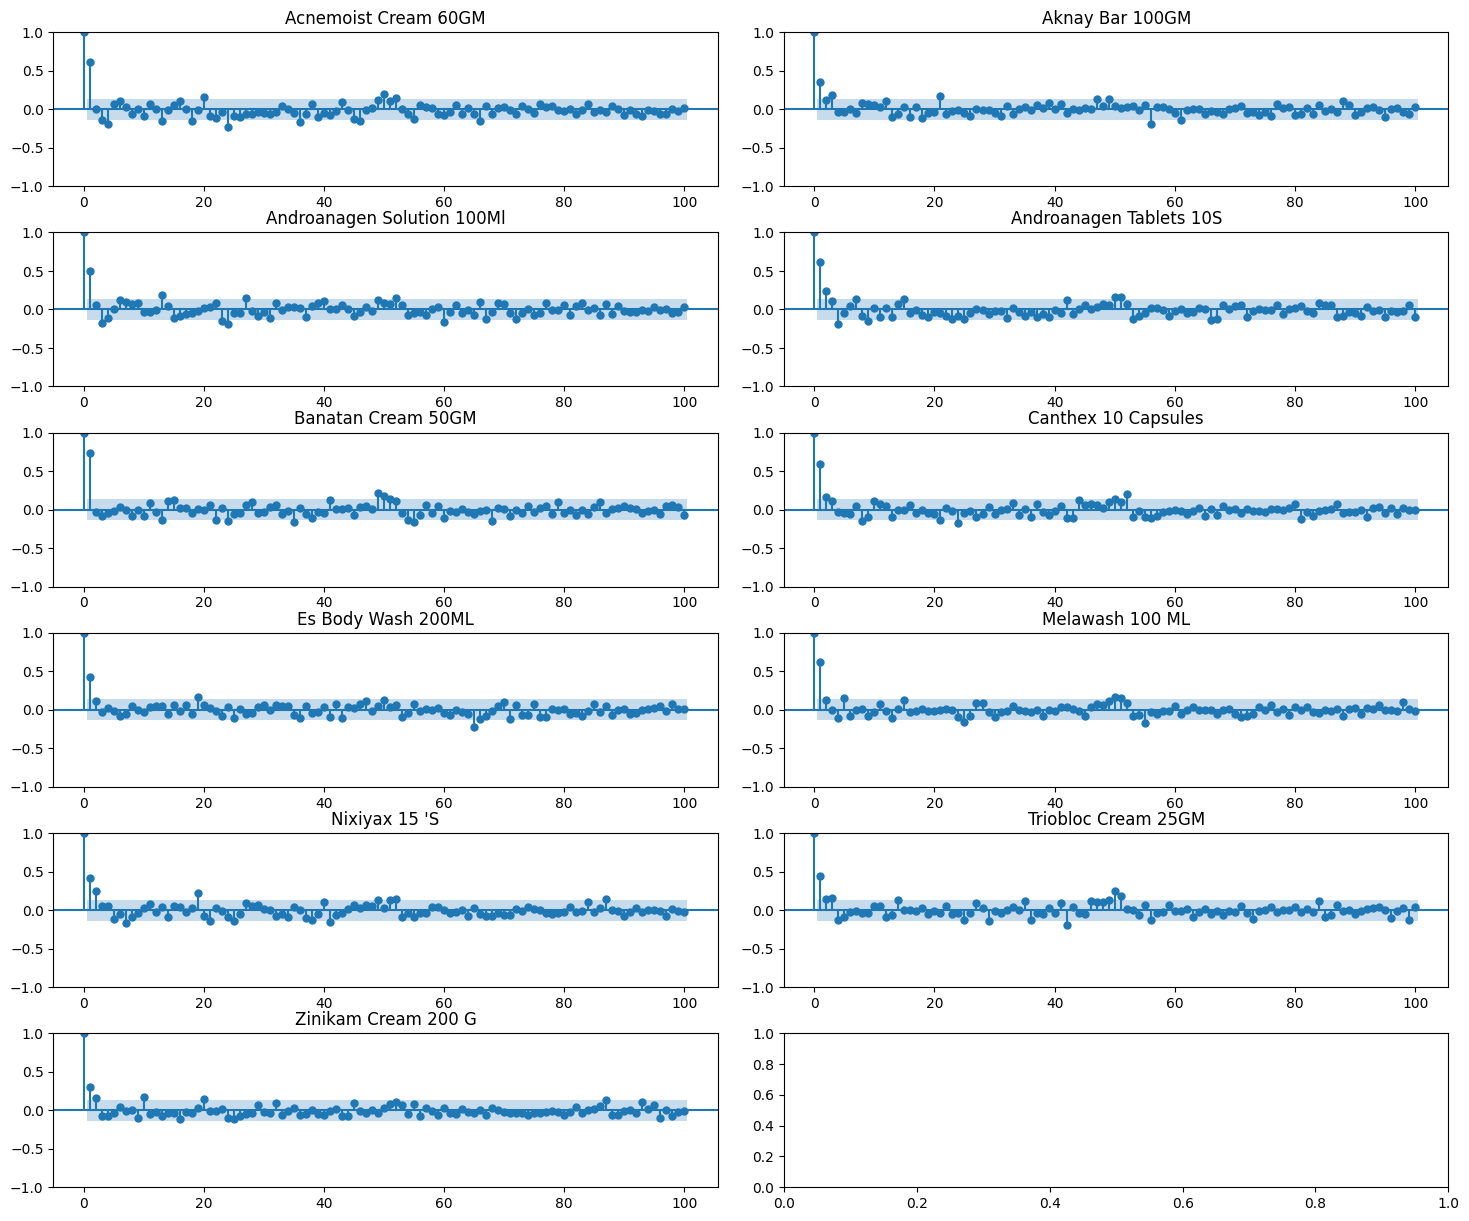

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
df = pd.read_csv('salesweekly.csv')
subplotindex=0
numrows=6
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(18,15))
    for x in ['Acnemoist Cream 60GM','Aknay Bar 100GM','Androanagen Solution 100Ml','Androanagen Tablets 10S', 'Banatan Cream 50GM','Canthex 10 Capsules','Es Body Wash 200ML','Melawash 100 ML',"Nixiyax 15 'S",'Triobloc Cream 25GM','Zinikam Cream 200 G']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_pacf(df[x], lags=100, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

Minor autocorrelation is observed at ACF (Auto-Correlation Function) and PACF (Partial Auto-Correlation Function) plots for all series

### 4.2.5. Data distribution analysis

In [13]:
resultsRolling={'Acnemoist Cream 60GM':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Aknay Bar 100GM':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Androanagen Solution 100Ml':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Androanagen Tablets 10S':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Banatan Cream 50GM':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Canthex 10 Capsules':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Es Body Wash 200ML':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Melawash 100 ML':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     "Nixiyax 15 'S":[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Triobloc Cream 25GM':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Zinikam Cream 200 G':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]}
resultsRollingdf = pd.DataFrame(resultsRolling)
resultsRollingdf.index = ['Naive MSE', 'Naive MAPE', 'Seasonal Naive MSE', 'Seasonal Naive MAPE',
                          'ARIMA MSE', 'ARIMA MAPE', 'AutoARIMA MSE', 'AutoARIMA MAPE',
                         'Prophet MSE', 'Prophet MAPE']
resultsLongterm={'Acnemoist Cream 60GM':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Aknay Bar 100GM':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Androanagen Solution 100Ml':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Androanagen Tablets 10S':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Banatan Cream 50GM':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Canthex 10 Capsules':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Es Body Wash 200ML':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Melawash 100 ML':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     "Nixiyax 15 'S":[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Triobloc Cream 25GM':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Zinikam Cream 200 G':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]}
resultsLongtermdf = pd.DataFrame(resultsLongterm)
resultsLongtermdf.index = ['Average MSE', 'Average MAPE', 'ARIMA MSE', 'ARIMA MAPE',
                           'AutoARIMA MSE', 'AutoARIMA MAPE', 'Prophet MSE', 'Prophet MAPE',
                          'Vanilla LSTM MSE', 'Vanilla LSTM MAPE', 'Stacked LSTM MSE', 'Stacked LSTM MAPE',
                          'Bidirectional LSTM MSE', 'Bidirectional LSTM MAPE']

In this subsection, three summaries of the reference benchmarks, namely Naïve methods are provided. First, Naïve forecasting was done and results presented. Second, average method was used to forecast. Finally, seasonal Naïve forecast was carried out for the series that has been found as seasonal: N02BE, R03 and R06. See Theoretical background section for explanation of those methods.

#### 4.3.1.1. Naïve forecasting

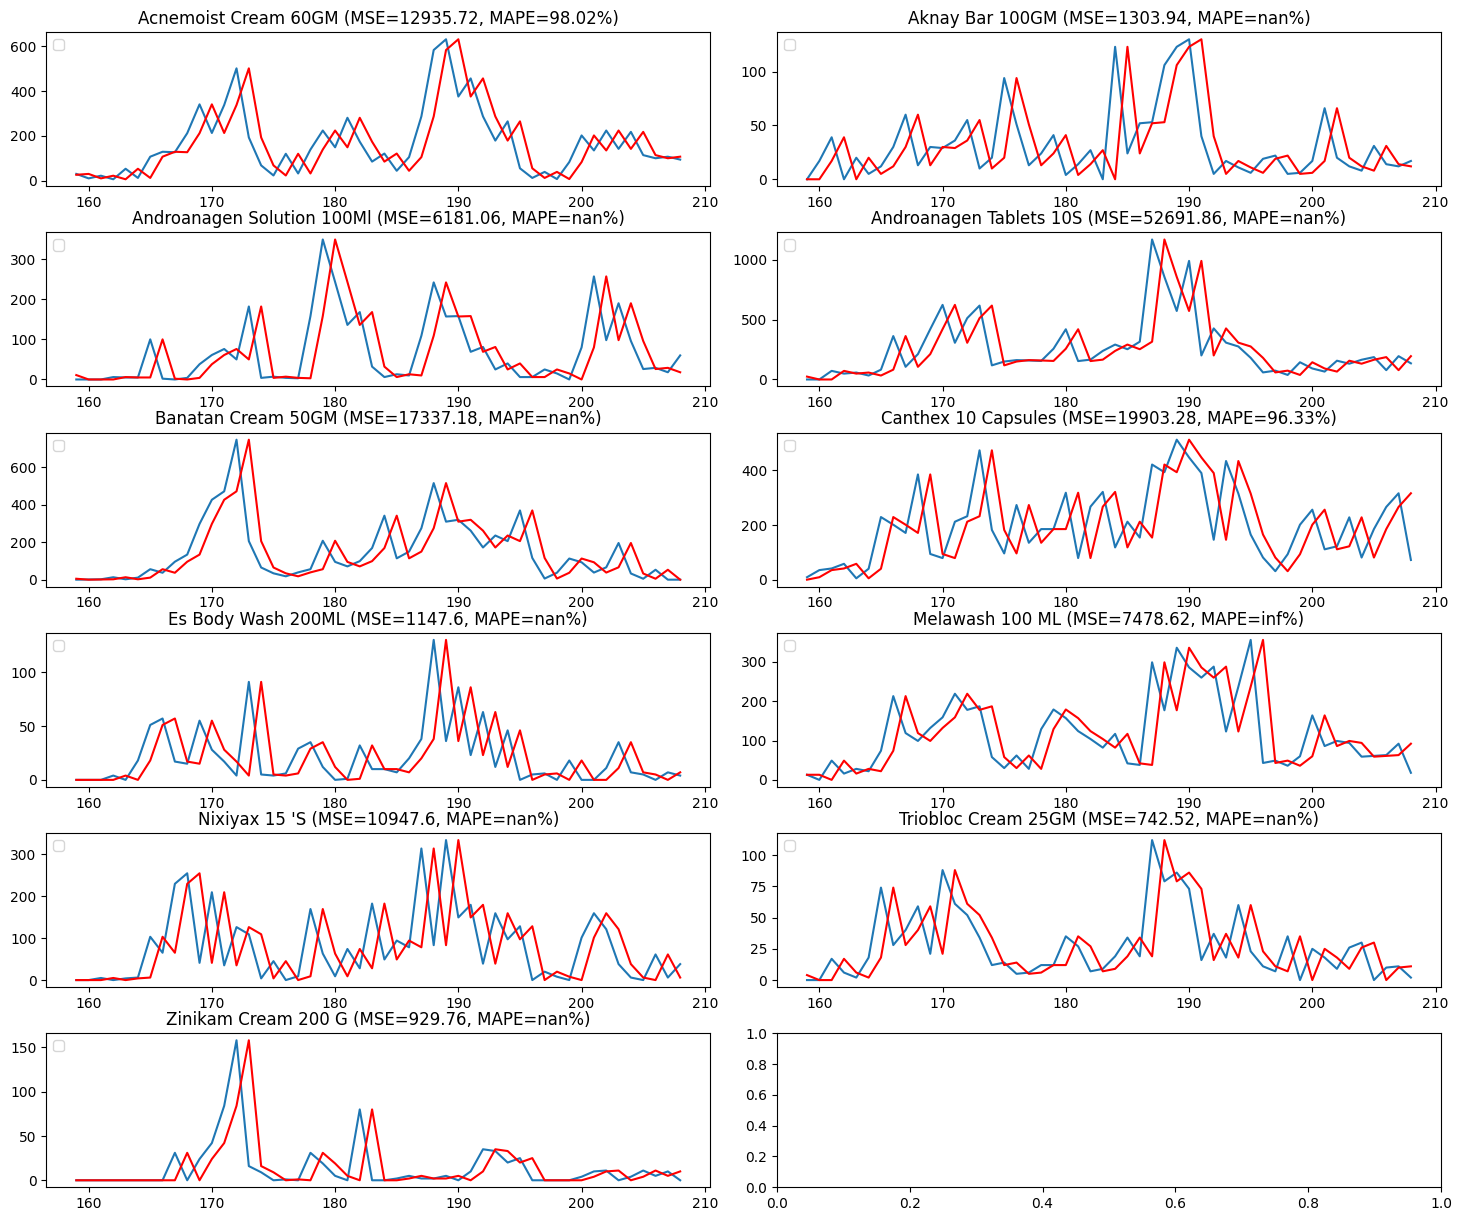

In [14]:
df = pd.read_csv('salesweekly.csv')
subplotindex=0
numrows=6
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['Acnemoist Cream 60GM','Aknay Bar 100GM','Androanagen Solution 100Ml','Androanagen Tablets 10S', 'Banatan Cream 50GM','Canthex 10 Capsules','Es Body Wash 200ML','Melawash 100 ML',"Nixiyax 15 'S",'Triobloc Cream 25GM','Zinikam Cream 200 G']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ds=df[x]
    dataframe = concat([ds.shift(1), ds], axis=1)
    dataframe.columns = ['t+1', 't-1']
    size = len(dataframe)-50
    X=dataframe['t-1']
    Y=dataframe['t+1']
    test, predictions = X[size:len(X)], Y[size:len(Y)]
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['Naive MSE',x]=error
    resultsRollingdf.loc['Naive MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

#### 4.3.1.2. Average method forecasting

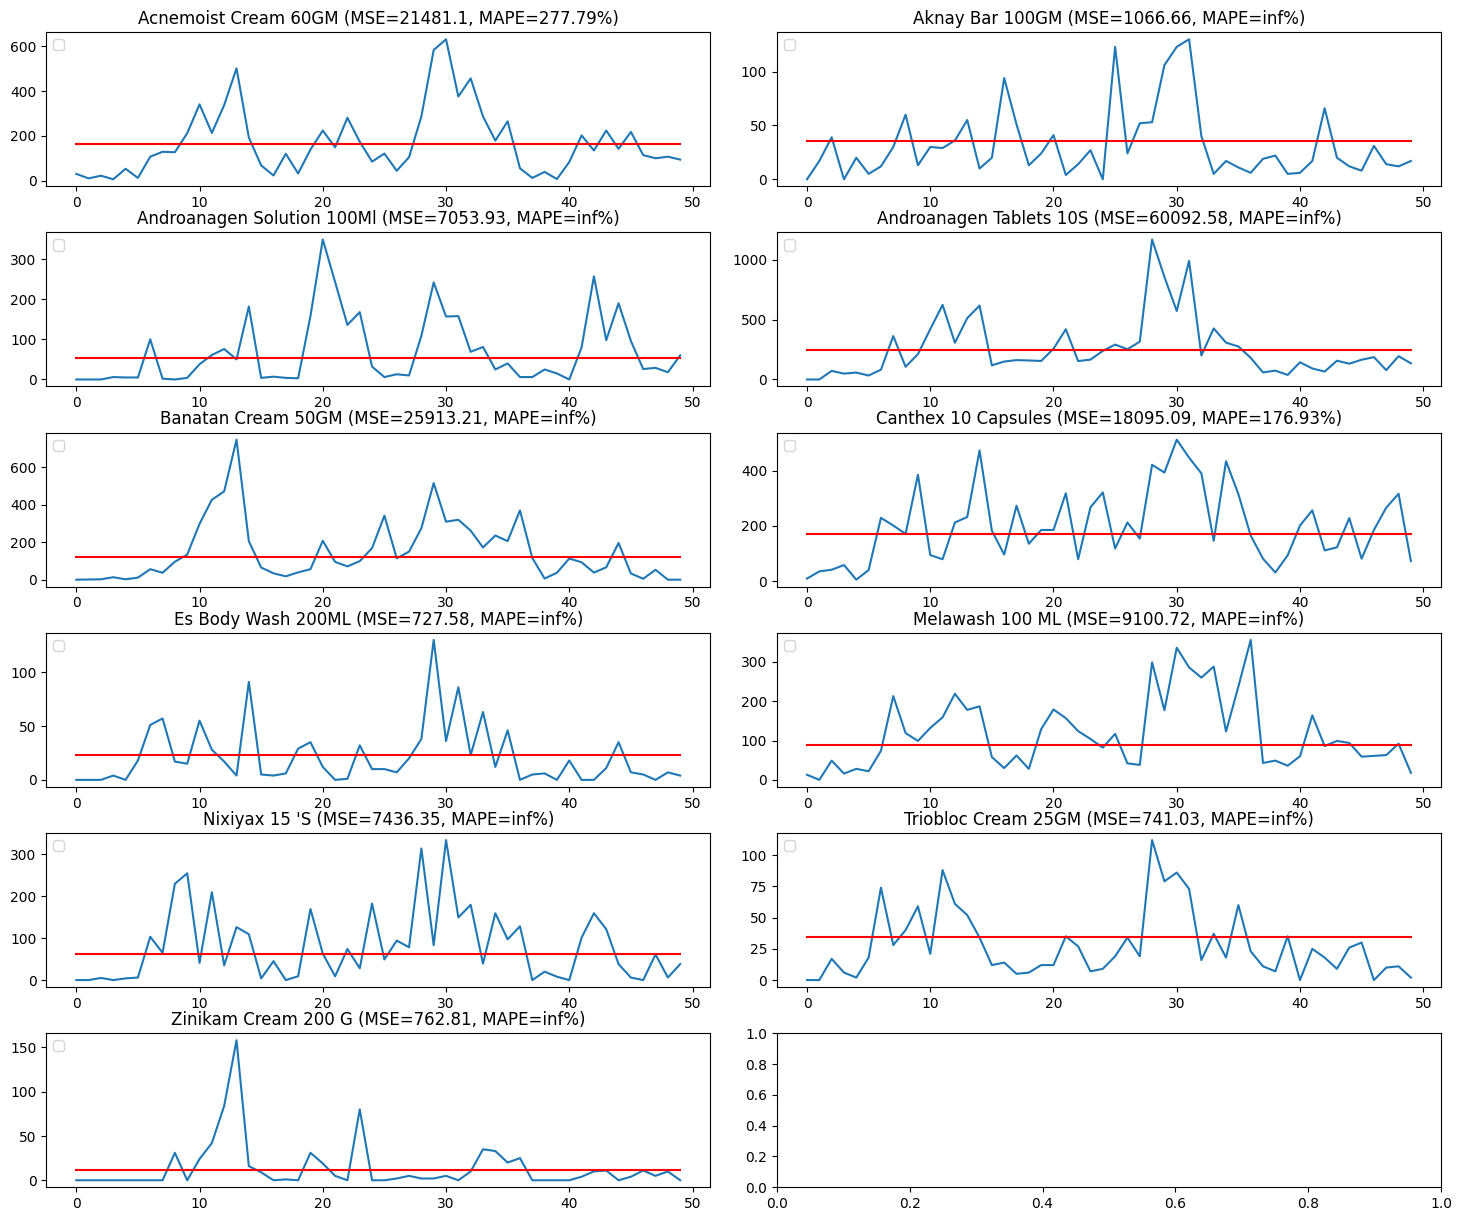

In [15]:
df = pd.read_csv('salesweekly.csv')
subplotindex=0
numrows=6
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['Acnemoist Cream 60GM','Aknay Bar 100GM','Androanagen Solution 100Ml','Androanagen Tablets 10S', 'Banatan Cream 50GM','Canthex 10 Capsules','Es Body Wash 200ML','Melawash 100 ML',"Nixiyax 15 'S",'Triobloc Cream 25GM','Zinikam Cream 200 G']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    size = len(X)-50
    test = X[size:len(X)]
    mean = np.mean(X[0:size])
    predictions = np.full(50,mean)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsLongtermdf.loc['Average MSE',x]=error
    resultsLongtermdf.loc['Average MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

#### 4.3.1.3. Seasonal Naïve forecasting

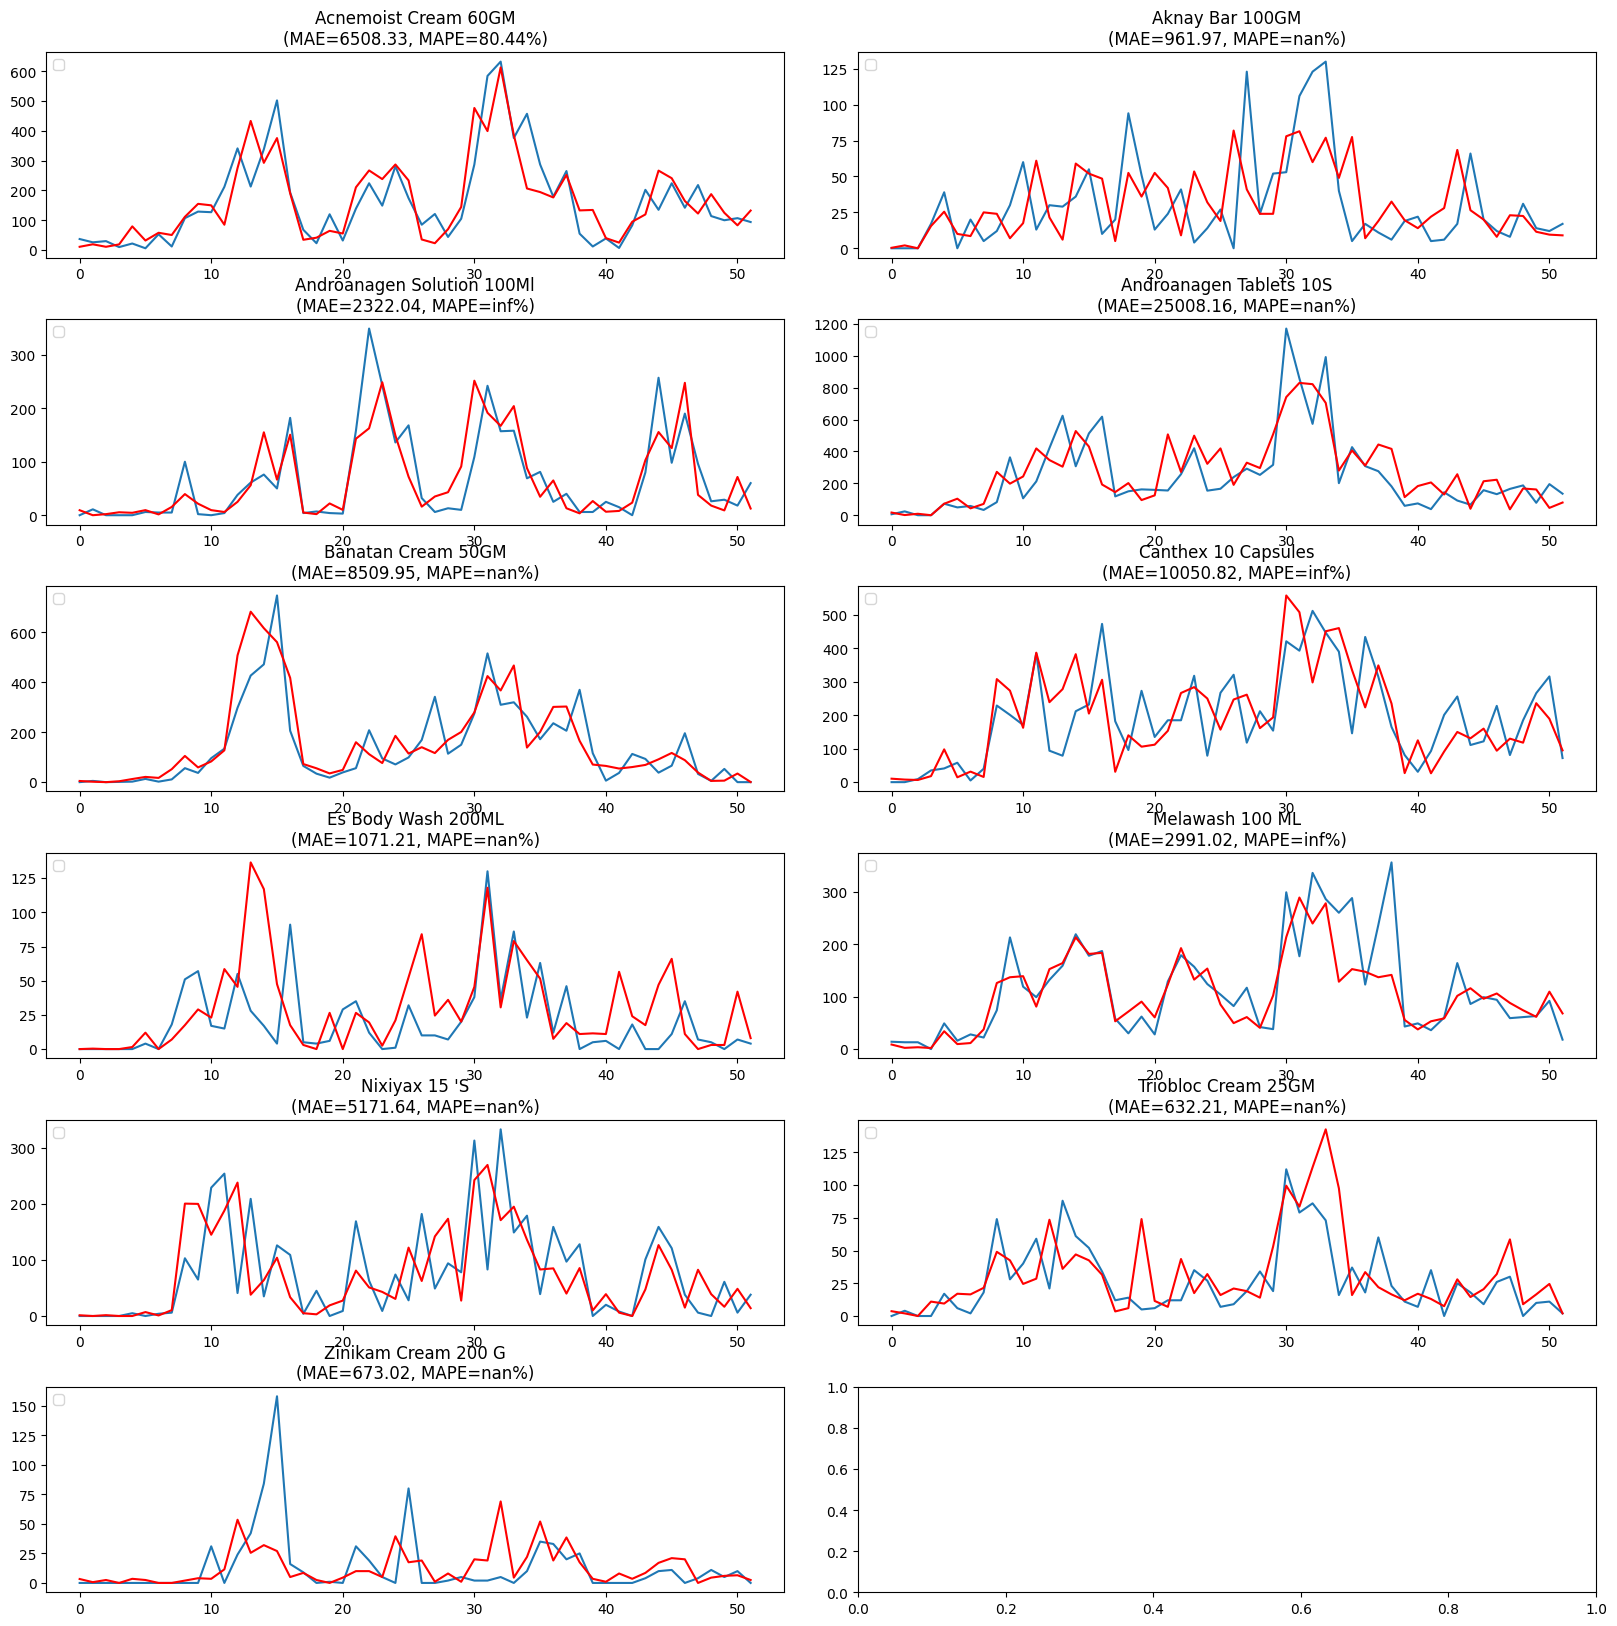

In [16]:
df = pd.read_csv('salesweekly.csv')
subplotindex = 0
numrows = 6
numcols = 2
fig, ax = plt.subplots(numrows, numcols, figsize=(20, 20))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for x in ['Acnemoist Cream 60GM', 'Aknay Bar 100GM', 'Androanagen Solution 100Ml', 'Androanagen Tablets 10S', 'Banatan Cream 50GM', 'Canthex 10 Capsules', 'Es Body Wash 200ML', 'Melawash 100 ML', "Nixiyax 15 'S", 'Triobloc Cream 25GM', 'Zinikam Cream 200 G']:
    rowindex = math.floor(subplotindex / numcols)
    colindex = subplotindex - (rowindex * numcols)
    X = df[x].values
    size = len(X) - 52
    test = X[size:len(X)]
    train = X[0:size]
    predictions = []

    history = [x for x in train]

    for i in range(len(test)):
        obs = [train[-(y * 52) + i] for y in range(1, min(5, (size - i) // 52 + 1))]
        yhat = np.mean(obs)
        predictions.append(yhat)

    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)

    resultsRollingdf.loc['Seasonal Naive MSE', x] = error
    resultsRollingdf.loc['Seasonal Naive MAPE', x] = perror

    ax[rowindex, colindex].set_title(x + '\n(MAE=' + str(round(error, 2)) + ', MAPE=' + str(round(perror, 2)) + '%)')
    ax[rowindex, colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex, colindex].plot(test)
    ax[rowindex, colindex].plot(predictions, color='red')
    subplotindex += 1

plt.show()


### 4.3.2. ARIMA Forecasting

ARIMA method was used to to carry out short-term (rolling forecast) and long-term forecasting based on test data. Before each forecast is made, the process of optimizing hyper-parameters (p,d,q) of ARIMA model was carry out. Then, with optimal set of parameters, rolling forecast and long-term forecasting was carried out. Seasonal ARIMA (SARIMA) method was tested by using Auto-ARIMA implementation. This implementation has built-in stepwise optimizer which chooses optimal set of parameters (p,d,q for non-seasonal and p,d,q,P,D,Q for seasonal series,

#### 4.3.2.1. Choosing parameters for ARIMA model

First, method arma_order_select_ic was used to determine initial p and q parameters. The method computes Akaike’s Information Criterion (AIC) for many ARIMA models and chooses the best configuration. It is important to note that AIC tend not to be a good guide to selecting the appropriate order of differencing (d) of a model, but only for selecting the values of p and q.

In [17]:
import statsmodels.api as sm
df = pd.read_csv('salesweekly.csv')
warnings.filterwarnings("ignore")
for x in ['Acnemoist Cream 60GM', 'Aknay Bar 100GM', 'Androanagen Solution 100Ml', 'Androanagen Tablets 10S', 'Banatan Cream 50GM', 'Canthex 10 Capsules', 'Es Body Wash 200ML', 'Melawash 100 ML', "Nixiyax 15 'S", 'Triobloc Cream 25GM', 'Zinikam Cream 200 G']:
    resDiff = sm.tsa.arma_order_select_ic(df[x], max_ar=5, max_ma=5, ic='aic', trend='c')
    print('ARMA(p,q,'+x+') =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q,Acnemoist Cream 60GM) = (3, 2) is the best.
ARMA(p,q,Aknay Bar 100GM) = (5, 5) is the best.
ARMA(p,q,Androanagen Solution 100Ml) = (4, 2) is the best.
ARMA(p,q,Androanagen Tablets 10S) = (3, 2) is the best.
ARMA(p,q,Banatan Cream 50GM) = (3, 2) is the best.
ARMA(p,q,Canthex 10 Capsules) = (4, 2) is the best.
ARMA(p,q,Es Body Wash 200ML) = (2, 0) is the best.
ARMA(p,q,Melawash 100 ML) = (3, 2) is the best.
ARMA(p,q,Nixiyax 15 'S) = (2, 4) is the best.
ARMA(p,q,Triobloc Cream 25GM) = (3, 2) is the best.
ARMA(p,q,Zinikam Cream 200 G) = (4, 2) is the best.


However, AIC is not used to score accuracy of the forecasting methods in this research. Mean squared error is used instead. For that, reason, grid search optimization method was applied, where different combinations of the hyper-parameters were used to calculate MSE and then, the combination producing the least MSE was chosen as optimal. Grid search optimization is carried out for both approaches in forecasting: rolling and long-term.

Grid search optimization for rolling forecast produced the following best combinations of the hyper-parameters:

In [18]:
# def evaluate_arima_model(X, arima_order):
#     train_size = int(len(X) * 0.66)
#     train, test = X[0:train_size], X[train_size:]
#     history = [x for x in train]
#     predictions = list()
#     for t in range(len(test)):
#         model = ARIMA(history, order=arima_order)
#         model_fit = model.fit(disp=0)
#         yhat = model_fit.forecast()[0]
#         predictions.append(yhat)
#         history.append(test[t])
#     error = mean_squared_error(test, predictions)
#     return error

# def evaluate_models(f, dataset, p_values, d_values, q_values):
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p,d,q)
#                 try:
#                     mse = evaluate_arima_model(dataset, order)
#                     if mse < best_score:
#                         best_score, best_cfg = mse, order
#                 except:
#                     continue
#     print(f+' - Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# p_values = range(0, 6)
# d_values = range(0, 2)
# q_values = range(0, 6)

# warnings.filterwarnings("ignore")

# df = pd.read_csv('/content/salesweekly.csv')

# for f in ['Acnemoist Cream 60GM', 'Aknay Bar 100GM', 'Androanagen Solution 100Ml', 'Androanagen Tablets 10S', 'Banatan Cream 50GM', 'Canthex 10 Capsules', 'Es Body Wash 200ML', 'Melawash 100 ML', "Nixiyax 15 'S", 'Triobloc Cream 25GM', 'Zinikam Cream 200 G']:
#     evaluate_models(f, df[f].values, p_values, d_values, q_values)

In [19]:
# import pandas as pd
# import numpy as np
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error

# def evaluate_arima_model(X, arima_order):
#     train_size = int(len(X) * 0.66)
#     train, test = X[0:train_size], X[train_size:]
#     history = [x for x in train]
#     predictions = list()
#     for t in range(len(test)):
#         model = ARIMA(history, order=arima_order)
#         model_fit = model.fit()
#         yhat = model_fit.forecast()[0]
#         predictions.append(yhat)
#         history.append(test[t])
#     error = mean_squared_error(test, predictions)
#     return error

# def evaluate_models(product, dataset, p_values, d_values, q_values):
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p, d, q)
#                 try:
#                     mse = evaluate_arima_model(dataset, order)
#                     if mse < best_score:
#                         best_score, best_cfg = mse, order
#                 except:
#                     continue
#     print(f'{product} - Best ARIMA{best_cfg} MSE={best_score:.3f}')

# # Load your dataset (replace 'your_data.csv' with your actual file)
# df = pd.read_csv('salesweekly.csv')

# # Define hyperparameter ranges
# p_values = range(0, 6)
# d_values = range(0, 2)
# q_values = range(0, 6)

# # Specify the products you want to evaluate
# products_to_evaluate = ['Acnemoist Cream 60GM', 'Aknay Bar 100GM', 'Androanagen Solution 100Ml',
#                          'Androanagen Tablets 10S', 'Banatan Cream 50GM', 'Canthex 10 Capsules',
#                          'Es Body Wash 200ML', 'Melawash 100 ML', "Nixiyax 15 'S", 'Triobloc Cream 25GM',
#                          'Zinikam Cream 200 G']

# # Evaluate ARIMA models for each product
# for product in products_to_evaluate:
#     product_data = df[product].diff().dropna()  # Apply differencing to make the data stationary
#     evaluate_models(product, product_data.values, p_values, d_values, q_values)


Grid search optimization for long-term forecast produced the following best combinations of the hyper-parameters:

In [20]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

def evaluate_arima_model(X):
    train_size = int(len(X) - 50)
    train, test = X[0:train_size], X[train_size:]

    # Automatically select the best ARIMA model
    model = auto_arima(train, suppress_warnings=True, seasonal=False)

    # Forecast the test set
    forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)

    # Calculate the mean squared error
    error = mean_squared_error(test, forecast)

    # Get the best model parameters
    best_params = model.get_params()

    return error, best_params

def evaluate_models(f, dataset):
    mse, best_params = evaluate_arima_model(dataset)
    print(f'{f} - Best ARIMA Model MSE={mse:.3f}, Best Parameters: {best_params}')

# Load your dataset (replace 'your_data.csv' with your actual file)
df = pd.read_csv('salesweekly.csv')

# Specify the products you want to evaluate
products_to_evaluate = ['Acnemoist Cream 60GM', 'Aknay Bar 100GM', 'Androanagen Solution 100Ml',
                         'Androanagen Tablets 10S', 'Banatan Cream 50GM', 'Canthex 10 Capsules',
                         'Es Body Wash 200ML', 'Melawash 100 ML', "Nixiyax 15 'S", 'Triobloc Cream 25GM',
                         'Zinikam Cream 200 G']

# Evaluate ARIMA models for each product
for product in products_to_evaluate:
    product_data = df[product].diff().dropna()  # Apply differencing to make the data stationary
    evaluate_models(product, product_data.values)


Acnemoist Cream 60GM - Best ARIMA Model MSE=13000.862, Best Parameters: {'maxiter': 50, 'method': 'lbfgs', 'order': (0, 0, 2), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}
Aknay Bar 100GM - Best ARIMA Model MSE=1304.495, Best Parameters: {'maxiter': 50, 'method': 'lbfgs', 'order': (0, 0, 2), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}
Androanagen Solution 100Ml - Best ARIMA Model MSE=6216.526, Best Parameters: {'maxiter': 50, 'method': 'lbfgs', 'order': (3, 0, 1), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}
Androanagen Tablets 10S - Best ARIMA Model MSE=52709.457, Best Param

From the optimization stand of point, some series are considered as so-called white noise - random time series data. Those are series for whom the best result was achieved with p=0, d=0 and q=0.

#### 4.3.2.2. Rolling forecasting with ARIMA model

In [22]:
from statsmodels.tsa.arima.model import ARIMA

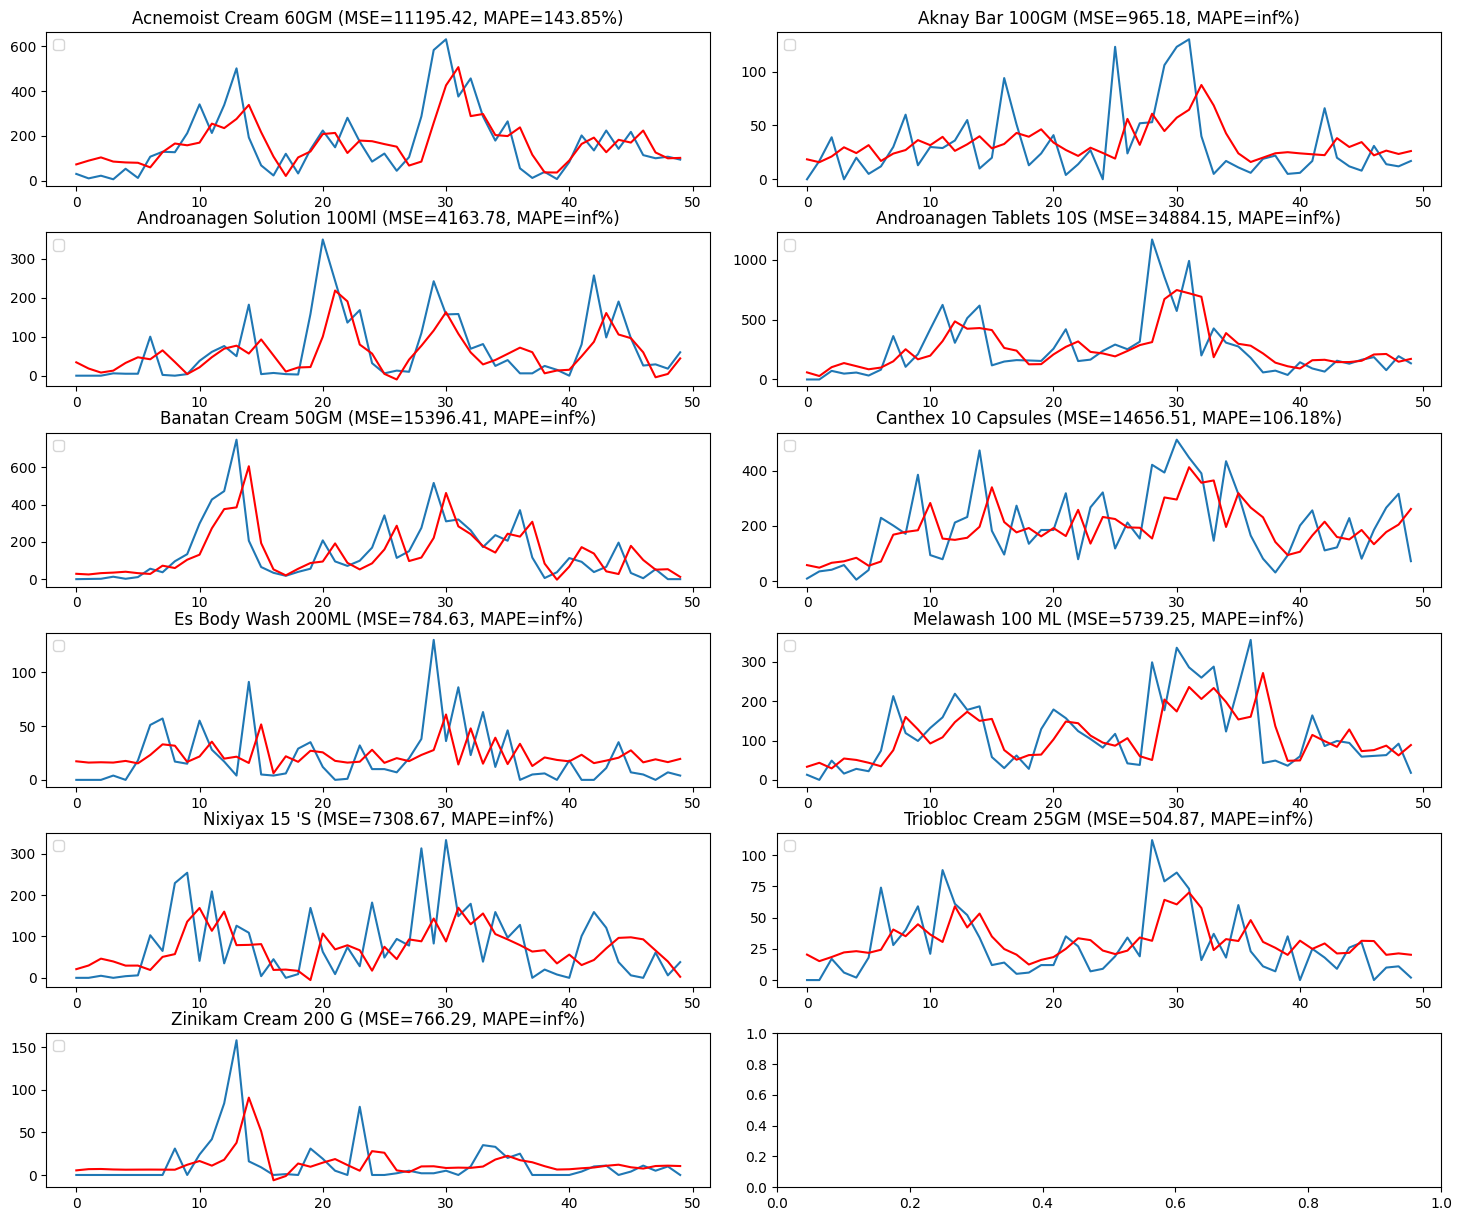

In [23]:
df = pd.read_csv('salesweekly.csv')

Acnemoist_Cream_60GM= {'series':'Acnemoist Cream 60GM','p':4,'d':0,'q':3}
Aknay_Bar_100GM= {'series':'Aknay Bar 100GM','p':4,'d':0,'q':2}
Androanagen_Solution_100Ml= {'series':'Androanagen Solution 100Ml','p':2,'d':0,'q':4}
Androanagen_Tablets_10S= {'series':'Androanagen Tablets 10S','p':3,'d':0,'q':3}
Banatan_Cream_50GM= {'series':'Banatan Cream 50GM','p':3,'d':0,'q':2}
Canthex_10_Capsules= {'series':'Canthex 10 Capsules','p':3,'d':0,'q':1}
Es_Body_Wash_200ML= {'series':'Es Body Wash 200ML','p':0,'d':0,'q':1}
Melawash_100_ML= {'series':'Melawash 100 ML','p':5,'d':0,'q':2}
Nixiyax_15_S= {'series':"Nixiyax 15 'S",'p':4,'d':0,'q':5}
Triobloc_Cream_25GM= {'series':'Triobloc Cream 25GM','p':5,'d':0,'q':4}
Zinikam_Cream_200_G= {'series':'Zinikam Cream 200 G','p':0,'d':0,'q':4}

subplotindex=0
numrows=6
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in [Acnemoist_Cream_60GM,Aknay_Bar_100GM,Androanagen_Solution_100Ml,Androanagen_Tablets_10S,Banatan_Cream_50GM,Canthex_10_Capsules,Es_Body_Wash_200ML,Melawash_100_ML,Nixiyax_15_S,Triobloc_Cream_25GM,Zinikam_Cream_200_G]:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x['series']].values
    size = len(X)-50
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(x['p'],x['d'],x['q']))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['ARIMA MSE',x['series']]=error
    resultsRollingdf.loc['ARIMA MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()


#### 4.3.2.3. Long-term forecasting with ARIMA model

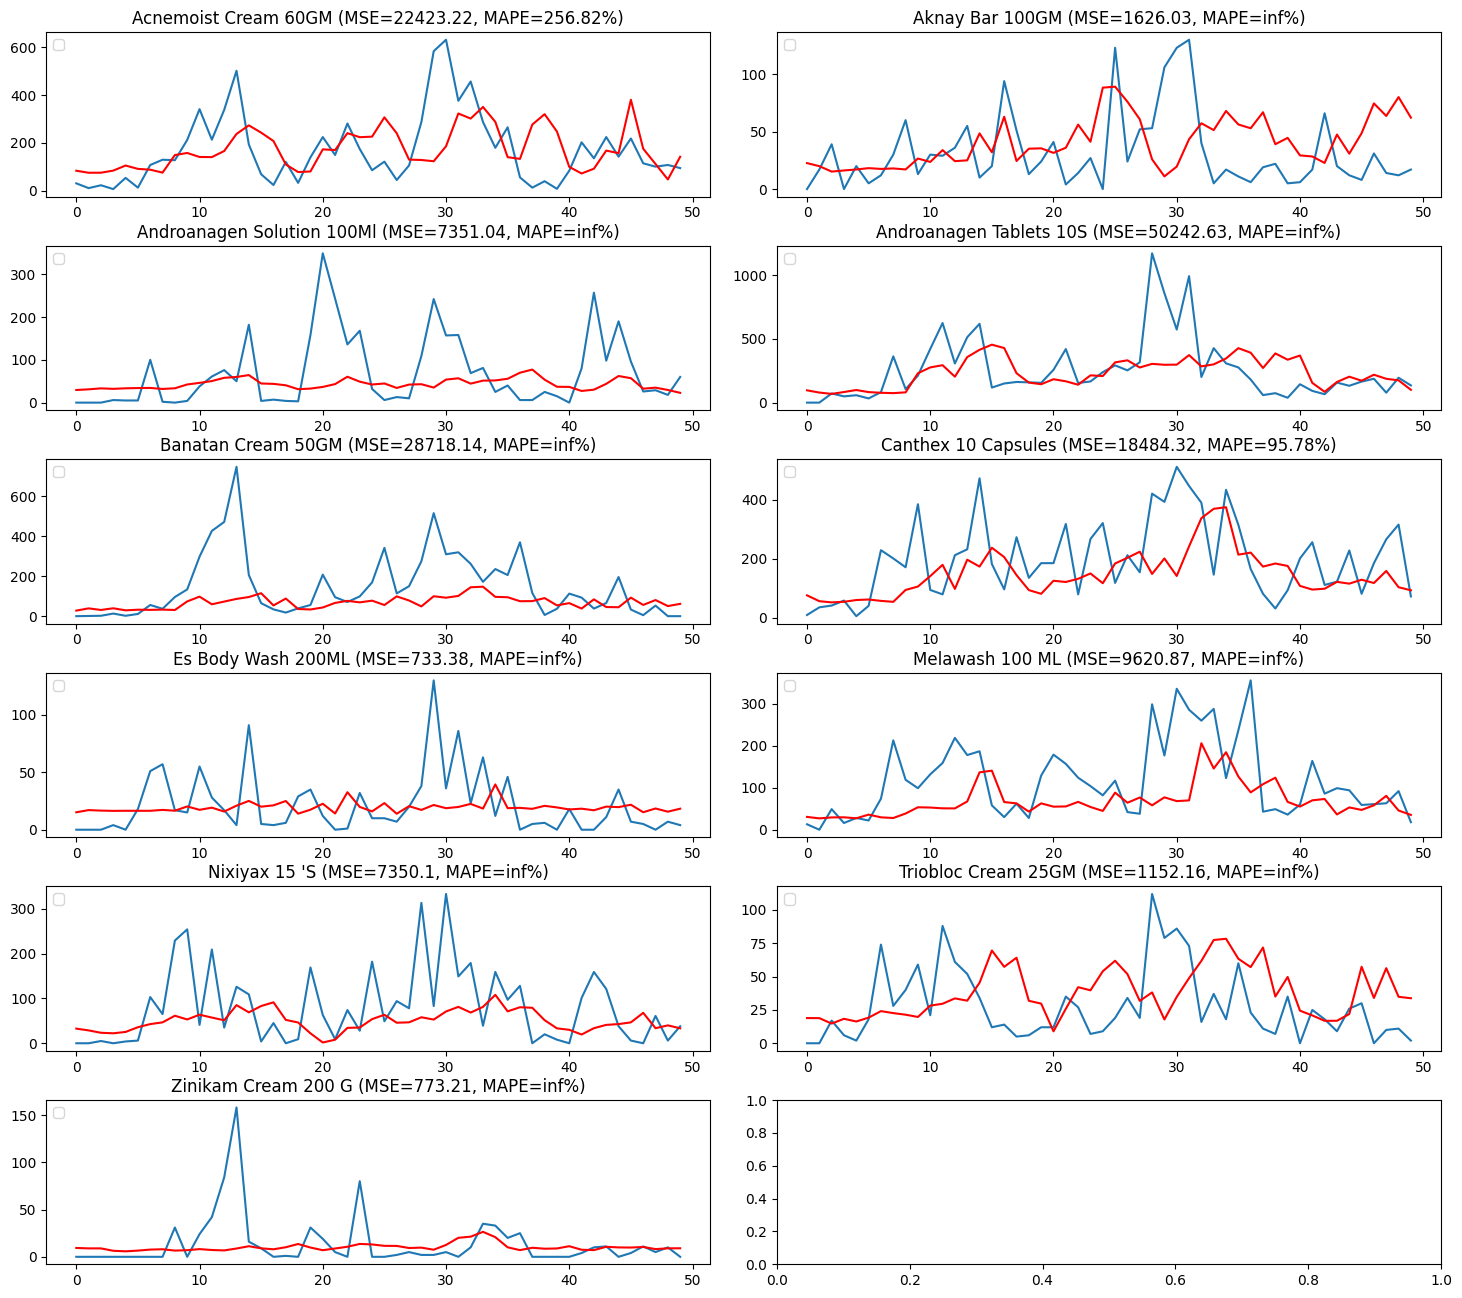

In [24]:
df = pd.read_csv('salesweekly.csv')

Acnemoist_Cream_60GM= {'series':'Acnemoist Cream 60GM','p':4,'d':0,'q':3}
Aknay_Bar_100GM= {'series':'Aknay Bar 100GM','p':4,'d':0,'q':2}
Androanagen_Solution_100Ml= {'series':'Androanagen Solution 100Ml','p':2,'d':0,'q':4}
Androanagen_Tablets_10S= {'series':'Androanagen Tablets 10S','p':3,'d':0,'q':3}
Banatan_Cream_50GM= {'series':'Banatan Cream 50GM','p':3,'d':0,'q':2}
Canthex_10_Capsules= {'series':'Canthex 10 Capsules','p':3,'d':0,'q':1}
Es_Body_Wash_200ML= {'series':'Es Body Wash 200ML','p':0,'d':0,'q':1}
Melawash_100_ML= {'series':'Melawash 100 ML','p':5,'d':0,'q':2}
Nixiyax_15_S= {'series':"Nixiyax 15 'S",'p':4,'d':0,'q':5}
Triobloc_Cream_25GM= {'series':'Triobloc Cream 25GM','p':5,'d':0,'q':4}
Zinikam_Cream_200_G= {'series':'Zinikam Cream 200 G','p':0,'d':0,'q':4}

subplotindex=0
numrows=6
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,16))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in [Acnemoist_Cream_60GM,Aknay_Bar_100GM,Androanagen_Solution_100Ml,Androanagen_Tablets_10S,Banatan_Cream_50GM,Canthex_10_Capsules,Es_Body_Wash_200ML,Melawash_100_ML,Nixiyax_15_S,Triobloc_Cream_25GM,Zinikam_Cream_200_G]:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x['series']].values
    size = int(len(X) - 50)
    train, test = X[0:size], X[size:len(X)]
    model = ARIMA(train, order=(x['p'],x['d'],x['q']))
    model_fit = model.fit()
    forecast = model_fit.predict(1,len(test))
    error = mean_squared_error(test, forecast)
    perror = mean_absolute_percentage_error(test, forecast)
    resultsLongtermdf.loc['ARIMA MSE',x['series']]=error
    resultsLongtermdf.loc['ARIMA MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(forecast, color='red')
    subplotindex=subplotindex+1
plt.show()

#### 4.3.2.4. Rolling forecasting with Auto-ARIMA model

In [25]:
!pip install pmdarima

In [ ]:
from pmdarima import auto_arima

df = pd.read_csv('salesweekly.csv')
subplotindex=0
numrows=6
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in ['Acnemoist Cream 60GM', 'Aknay Bar 100GM']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x].values
    size = len(X)-50
    train, test = X[0:size], X[size:len(X)]
    history = [c for c in train]
    predictions = list()
    for t in range(len(test)):
        if (x=='Acnemoist Cream 60GM' or x=='Aknay Bar 100GM'):
            model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=52, max_d=1, max_D=1,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, seasonal=True,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
        else:
            model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, max_d=1,
                           trace=False, seasonal=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
        model_fit = model.fit(history)
        output = model_fit.predict(n_periods=1)
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['AutoARIMA MSE',x]=error
    resultsRollingdf.loc['AutoARIMA MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

#### 4.3.2.5. Long-term forecasting with Auto-ARIMA model

In [ ]:
from pmdarima import auto_arima

df = pd.read_csv('salesweekly.csv')
subplotindex=0
numrows=6
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in ['Acnemoist Cream 60GM', 'Aknay Bar 100GM']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x].values
    size = int(len(X) - 50)
    train, test = X[0:size], X[size:len(X)]
    if (x=='Acnemoist Cream 60GM' or x=='Aknay Bar 100GM'):
        model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=52, max_d=1, max_D=1,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, seasonal=True,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
    else:
        model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, max_d=1,
                           trace=False, seasonal=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
    model_fit = model.fit(train)
    forecast = model_fit.predict(n_periods=len(test))
    error = mean_squared_error(test, forecast)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsLongtermdf.loc['AutoARIMA MSE',x]=error
    resultsLongtermdf.loc['AutoARIMA MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(forecast, color='red')
    subplotindex=subplotindex+1
plt.show()

### 4.3.3. Prophet forecasting

Prophet model is fited with data in two columns, where first one contains time information and is labeled as ds. Another stores actual time series data and is labeled as y.

Prophet model is tuned by using the following hyper-parameters:

- growth. For a linear trending, value should be 'linear'. If not, 'logistic'. In latter case, the cap (maximum value data will reach) and floor (minimum value data will reach) of your predictions need to be provided. This is typically determined by domain experts.
- interval_width. the uncertainty interval to produce a confidence interval around the forecast.
- fourier_order. the number of Fourier components each seasonality is composed of.
- n_changepoints. The changepoints parameter is used when the changepoint dates are supplied instead of having Prophet determine them. In practice Prophet should be let to do that alone.
- changepoint_range usually does not have that much of an effect on the performance.
- changepoint_prior_scale, is there to indicate how flexible the changepoints are allowed to be. In other words, how much can the changepoints fit to the data. If high it will be more flexible, but then overfitting is possible.
- seasonality_prior_scale parameter. This parameter will again allow your seasonalities to be more flexible.

<blockquote>While Prophet model is used both for rolling forecasts and long-term forecasting, optimization of hyper-parameters is carried out only for long-term forecasts. Optimal sets of hyper-parameters are then used also for rolling forecasts.</blockquote>

#### 4.3.3.1. Grid-search optimization of Prophet hyper-parameters

Before actual forecasting, the optimal set of hyper-parameters is determined by using grid-search method. NOTE: this is illustrative example; actual optimization is carried out with larger intervals of hyper-parameters' values.

In [31]:
!pip install prophet

In [32]:
from prophet import Prophet
df = pd.read_csv('salesweekly.csv')

Acnemoist_Cream_60GM= {
    'series':'Acnemoist Cream 60GM',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[10,30,50],
               'interval_width':[0.0005]
              }
}
Aknay_Bar_100GM= {
    'series':'Aknay Bar 100GM',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],
               'interval_width':[0.0005]
              }
}
Androanagen_Solution_100Ml= {
    'series':'Androanagen Solution 100Ml',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.005,0.01,0.05,0.1],
                   'interval_width':[0.0005]
              }
}
Androanagen_Tablets_10S= {
    'series':'Androanagen Tablets 10S',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[5,10,50],'seasonality_prior_scale':[150,170,200],
               'interval_width':[0.0005]
              }
}
Banatan_Cream_50GM= {
    'series':'Banatan Cream 50GM',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[1,5,10],
               'interval_width':[0.0005]
              }
}
Canthex_10_Capsules= {
    'series':'Canthex 10 Capsules',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.05,0.08,0.1,0.5],
               'interval_width':[0.0005]
              }
}
Es_Body_Wash_200ML= {
    'series':'Es Body Wash 200ML',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],'seasonality_prior_scale':[120,160,200],
               'interval_width':[0.0005]
              }
}
Melawash_100_ML= {
    'series':'Melawash 100 ML',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],'seasonality_prior_scale':[100,120,160,200],
               'interval_width':[0.0005]
              }
}
Nixiyax_15_S= {
    'series':"Nixiyax 15 'S",
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],'seasonality_prior_scale':[100,120,160,200],
               'interval_width':[0.0005]
              }
}
Triobloc_Cream_25GM= {
    'series':'Triobloc Cream 25GM',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],'seasonality_prior_scale':[100,120,160,200],
               'interval_width':[0.0005]
              }
}
Zinikam_Cream_200_G= {
    'series':'Zinikam Cream 200 G',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],'seasonality_prior_scale':[100,120,160,200],
               'interval_width':[0.0005]
              }
}

r=[Acnemoist_Cream_60GM,Aknay_Bar_100GM,Androanagen_Solution_100Ml,Androanagen_Tablets_10S,Banatan_Cream_50GM,Canthex_10_Capsules,Es_Body_Wash_200ML,Melawash_100_ML,Nixiyax_15_S,Triobloc_Cream_25GM,Zinikam_Cream_200_G]
warnings.filterwarnings("ignore")

for x in r:
    dfg=df[['datum',x['series']]]
    dfg = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
    size = int(len(dfg) - 50)
    dfgtrain=dfg.loc[0:size,:]
    dfgtest=dfg.loc[size+1:len(dfg),:]
    predictions = list()
    minError=0
    grid = ParameterGrid(x['params_grid'])
    for p in grid:
        model = Prophet(**p, daily_seasonality=False, weekly_seasonality=False)
        if(x=='Acnemoist Cream 60GM' or x=='Aknay Bar 100GM' or x=='Androanagen Solution 100Ml' or x=='Androanagen Tablets 10S'or x=='Banatan Cream 50GM'or x=='Canthex 10 Capsules' or x=='Es Body Wash 200ML' or x=='Melawash 100 ML' or x=="Nixiyax 15 'S" or x=='Triobloc Cream 25GM' or x == 'Zinikam Cream 200 G' ):
            model=model.add_seasonality(
                                name='yearly',
                                period=365.25,
                                fourier_order=13)
        model_fit = model.fit(dfgtrain)
        future = model.make_future_dataframe(periods=50, freq='W')
        output = model.predict(future)
        predictions=output.loc[size+2:len(dfg),:]['yhat'].values
        error = mean_squared_error(dfgtest['y'].values, predictions)
        if(minError>0):
            if(error<minError):
                minError=error
                minP=p
        else:
            minError=error
            minP=p

    print(minP)
    print('Test MSE ('+x['series']+'): %.3f' % minError)

10:17:47 - cmdstanpy - INFO - Chain [1] start processing
10:17:47 - cmdstanpy - INFO - Chain [1] done processing
10:17:47 - cmdstanpy - INFO - Chain [1] start processing
10:17:47 - cmdstanpy - INFO - Chain [1] done processing
10:17:47 - cmdstanpy - INFO - Chain [1] start processing
10:17:48 - cmdstanpy - INFO - Chain [1] done processing
10:17:48 - cmdstanpy - INFO - Chain [1] start processing
10:17:48 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 50, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (Acnemoist Cream 60GM): 13791.145


10:17:48 - cmdstanpy - INFO - Chain [1] start processing
10:17:48 - cmdstanpy - INFO - Chain [1] done processing
10:17:48 - cmdstanpy - INFO - Chain [1] start processing
10:17:48 - cmdstanpy - INFO - Chain [1] done processing
10:17:48 - cmdstanpy - INFO - Chain [1] start processing
10:17:48 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (Aknay Bar 100GM): 912.195


10:17:48 - cmdstanpy - INFO - Chain [1] start processing
10:17:49 - cmdstanpy - INFO - Chain [1] done processing
10:17:49 - cmdstanpy - INFO - Chain [1] start processing
10:17:49 - cmdstanpy - INFO - Chain [1] done processing
10:17:49 - cmdstanpy - INFO - Chain [1] start processing
10:17:49 - cmdstanpy - INFO - Chain [1] done processing
10:17:49 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (Androanagen Solution 100Ml): 3371.805


10:17:49 - cmdstanpy - INFO - Chain [1] done processing
10:17:49 - cmdstanpy - INFO - Chain [1] start processing
10:17:49 - cmdstanpy - INFO - Chain [1] done processing
10:17:50 - cmdstanpy - INFO - Chain [1] start processing
10:17:50 - cmdstanpy - INFO - Chain [1] done processing
10:17:50 - cmdstanpy - INFO - Chain [1] start processing
10:17:50 - cmdstanpy - INFO - Chain [1] done processing
10:17:50 - cmdstanpy - INFO - Chain [1] start processing
10:17:50 - cmdstanpy - INFO - Chain [1] done processing
10:17:50 - cmdstanpy - INFO - Chain [1] start processing
10:17:50 - cmdstanpy - INFO - Chain [1] done processing
10:17:50 - cmdstanpy - INFO - Chain [1] start processing
10:17:51 - cmdstanpy - INFO - Chain [1] done processing
10:17:51 - cmdstanpy - INFO - Chain [1] start processing
10:17:51 - cmdstanpy - INFO - Chain [1] done processing
10:17:51 - cmdstanpy - INFO - Chain [1] start processing
10:17:51 - cmdstanpy - INFO - Chain [1] done processing
10:17:51 - cmdstanpy - INFO - Chain [1] 

{'changepoint_prior_scale': 5, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 200}
Test MSE (Androanagen Tablets 10S): 29064.748


10:17:51 - cmdstanpy - INFO - Chain [1] start processing
10:17:52 - cmdstanpy - INFO - Chain [1] done processing
10:17:52 - cmdstanpy - INFO - Chain [1] start processing
10:17:52 - cmdstanpy - INFO - Chain [1] done processing
10:17:52 - cmdstanpy - INFO - Chain [1] start processing
10:17:52 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 5, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (Banatan Cream 50GM): 9019.632


10:17:52 - cmdstanpy - INFO - Chain [1] start processing
10:17:52 - cmdstanpy - INFO - Chain [1] done processing
10:17:52 - cmdstanpy - INFO - Chain [1] start processing
10:17:52 - cmdstanpy - INFO - Chain [1] done processing
10:17:53 - cmdstanpy - INFO - Chain [1] start processing
10:17:53 - cmdstanpy - INFO - Chain [1] done processing
10:17:53 - cmdstanpy - INFO - Chain [1] start processing
10:17:53 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.05, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (Canthex 10 Capsules): 10778.348


10:17:53 - cmdstanpy - INFO - Chain [1] start processing
10:17:53 - cmdstanpy - INFO - Chain [1] done processing
10:17:53 - cmdstanpy - INFO - Chain [1] start processing
10:17:53 - cmdstanpy - INFO - Chain [1] done processing
10:17:53 - cmdstanpy - INFO - Chain [1] start processing
10:17:53 - cmdstanpy - INFO - Chain [1] done processing
10:17:54 - cmdstanpy - INFO - Chain [1] start processing
10:17:54 - cmdstanpy - INFO - Chain [1] done processing
10:17:54 - cmdstanpy - INFO - Chain [1] start processing
10:17:54 - cmdstanpy - INFO - Chain [1] done processing
10:17:54 - cmdstanpy - INFO - Chain [1] start processing
10:17:54 - cmdstanpy - INFO - Chain [1] done processing
10:17:54 - cmdstanpy - INFO - Chain [1] start processing
10:17:54 - cmdstanpy - INFO - Chain [1] done processing
10:17:54 - cmdstanpy - INFO - Chain [1] start processing
10:17:54 - cmdstanpy - INFO - Chain [1] done processing
10:17:55 - cmdstanpy - INFO - Chain [1] start processing
10:17:55 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 160}
Test MSE (Es Body Wash 200ML): 814.519


10:17:55 - cmdstanpy - INFO - Chain [1] start processing
10:17:55 - cmdstanpy - INFO - Chain [1] done processing
10:17:55 - cmdstanpy - INFO - Chain [1] start processing
10:17:55 - cmdstanpy - INFO - Chain [1] done processing
10:17:55 - cmdstanpy - INFO - Chain [1] start processing
10:17:55 - cmdstanpy - INFO - Chain [1] done processing
10:17:55 - cmdstanpy - INFO - Chain [1] start processing
10:17:56 - cmdstanpy - INFO - Chain [1] done processing
10:17:56 - cmdstanpy - INFO - Chain [1] start processing
10:17:56 - cmdstanpy - INFO - Chain [1] done processing
10:17:56 - cmdstanpy - INFO - Chain [1] start processing
10:17:56 - cmdstanpy - INFO - Chain [1] done processing
10:17:56 - cmdstanpy - INFO - Chain [1] start processing
10:17:56 - cmdstanpy - INFO - Chain [1] done processing
10:17:56 - cmdstanpy - INFO - Chain [1] start processing
10:17:56 - cmdstanpy - INFO - Chain [1] done processing
10:17:56 - cmdstanpy - INFO - Chain [1] start processing
10:17:56 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.05, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 200}
Test MSE (Melawash 100 ML): 3915.283


10:17:57 - cmdstanpy - INFO - Chain [1] start processing
10:17:57 - cmdstanpy - INFO - Chain [1] done processing
10:17:57 - cmdstanpy - INFO - Chain [1] start processing
10:17:57 - cmdstanpy - INFO - Chain [1] done processing
10:17:58 - cmdstanpy - INFO - Chain [1] start processing
10:17:58 - cmdstanpy - INFO - Chain [1] done processing
10:17:58 - cmdstanpy - INFO - Chain [1] start processing
10:17:58 - cmdstanpy - INFO - Chain [1] done processing
10:17:58 - cmdstanpy - INFO - Chain [1] start processing
10:17:58 - cmdstanpy - INFO - Chain [1] done processing
10:17:58 - cmdstanpy - INFO - Chain [1] start processing
10:17:58 - cmdstanpy - INFO - Chain [1] done processing
10:17:58 - cmdstanpy - INFO - Chain [1] start processing
10:17:58 - cmdstanpy - INFO - Chain [1] done processing
10:17:59 - cmdstanpy - INFO - Chain [1] start processing
10:17:59 - cmdstanpy - INFO - Chain [1] done processing
10:17:59 - cmdstanpy - INFO - Chain [1] start processing
10:17:59 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.05, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 160}
Test MSE (Nixiyax 15 'S): 3915.768


10:17:59 - cmdstanpy - INFO - Chain [1] done processing
10:18:00 - cmdstanpy - INFO - Chain [1] start processing
10:18:00 - cmdstanpy - INFO - Chain [1] done processing
10:18:00 - cmdstanpy - INFO - Chain [1] start processing
10:18:00 - cmdstanpy - INFO - Chain [1] done processing
10:18:00 - cmdstanpy - INFO - Chain [1] start processing
10:18:00 - cmdstanpy - INFO - Chain [1] done processing
10:18:00 - cmdstanpy - INFO - Chain [1] start processing
10:18:00 - cmdstanpy - INFO - Chain [1] done processing
10:18:00 - cmdstanpy - INFO - Chain [1] start processing
10:18:01 - cmdstanpy - INFO - Chain [1] done processing
10:18:01 - cmdstanpy - INFO - Chain [1] start processing
10:18:01 - cmdstanpy - INFO - Chain [1] done processing
10:18:01 - cmdstanpy - INFO - Chain [1] start processing
10:18:01 - cmdstanpy - INFO - Chain [1] done processing
10:18:01 - cmdstanpy - INFO - Chain [1] start processing
10:18:01 - cmdstanpy - INFO - Chain [1] done processing
10:18:01 - cmdstanpy - INFO - Chain [1] 

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 100}
Test MSE (Triobloc Cream 25GM): 369.836


10:18:02 - cmdstanpy - INFO - Chain [1] start processing
10:18:02 - cmdstanpy - INFO - Chain [1] done processing
10:18:02 - cmdstanpy - INFO - Chain [1] start processing
10:18:02 - cmdstanpy - INFO - Chain [1] done processing
10:18:02 - cmdstanpy - INFO - Chain [1] start processing
10:18:02 - cmdstanpy - INFO - Chain [1] done processing
10:18:03 - cmdstanpy - INFO - Chain [1] start processing
10:18:03 - cmdstanpy - INFO - Chain [1] done processing
10:18:03 - cmdstanpy - INFO - Chain [1] start processing
10:18:03 - cmdstanpy - INFO - Chain [1] done processing
10:18:03 - cmdstanpy - INFO - Chain [1] start processing
10:18:03 - cmdstanpy - INFO - Chain [1] done processing
10:18:03 - cmdstanpy - INFO - Chain [1] start processing
10:18:03 - cmdstanpy - INFO - Chain [1] done processing
10:18:03 - cmdstanpy - INFO - Chain [1] start processing
10:18:03 - cmdstanpy - INFO - Chain [1] done processing
10:18:04 - cmdstanpy - INFO - Chain [1] start processing
10:18:04 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 100}
Test MSE (Zinikam Cream 200 G): 734.245


In [45]:
# df = pd.read_csv('salesweekly.csv')

# subplotindex=0
# numrows=6
# numcols=2
# fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
# plt.subplots_adjust(wspace=0.1, hspace=0.3)

# warnings.filterwarnings("ignore")

# Acnemoist_Cream_60GM= {'series':'Acnemoist Cream 60GM','params_grid':{'changepoint_prior_scale': 50, 'interval_width': 0.0005}}
# Aknay_Bar_100GM= {'series':'Aknay Bar 100GM','params_grid':{'changepoint_prior_scale': 0.01,  'interval_width': 0.0005}}
# Androanagen_Solution_100Ml= {'series':'Androanagen Solution 100Ml','params_grid':{'changepoint_prior_scale': 0.01,  'interval_width': 0.0005}}
# Androanagen_Tablets_10S= {'series':'Androanagen Tablets 10S','params_grid':{'changepoint_prior_scale': 5,  'interval_width': 0.0005, 'seasonality_prior_scale': 200}}
# Banatan_Cream_50GM= {'series':'Banatan Cream 50GM','params_grid':{'changepoint_prior_scale': 5,  'interval_width': 0.0005}}
# Canthex_10_Capsules= {'series':'Canthex 10 Capsules','params_grid':{'changepoint_prior_scale': 0.05,  'interval_width': 0.0005}}
# Es_Body_Wash_200ML= {'series':'Es Body Wash 200ML','params_grid':{'changepoint_prior_scale': 0.1,  'interval_width': 0.0005, 'seasonality_prior_scale': 120}}
# Melawash_100_ML= {'series':'Melawash 100 ML','params_grid':{'changepoint_prior_scale': 0.05,  'interval_width': 0.0005, 'seasonality_prior_scale': 200}}
# Nixiyax_15_S= {'series':"Nixiyax 15 'S",'params_grid':{'changepoint_prior_scale': 0.05, 'interval_width': 0.0005, 'seasonality_prior_scale': 120}}
# Triobloc_Cream_25GM= {'series':'Triobloc Cream 25GM','params_grid':{'changepoint_prior_scale': 0.01,  'interval_width': 0.0005, 'seasonality_prior_scale': 100}}
# Zinikam_Cream_200_G= {'series':'Zinikam Cream 200 G','params_grid':{'changepoint_prior_scale': 0.1,  'interval_width': 0.0005, 'seasonality_prior_scale': 120}}

# r=[Acnemoist_Cream_60GM,Aknay_Bar_100GM,Androanagen_Solution_100Ml,Androanagen_Tablets_10S,Banatan_Cream_50GM,Canthex_10_Capsules,Es_Body_Wash_200ML,Melawash_100_ML,Nixiyax_15_S,Triobloc_Cream_25GM,Zinikam_Cream_200_G]

# for x in r:
#     rowindex=math.floor(subplotindex/numcols)
#     colindex=subplotindex-(rowindex*numcols)
#     dfg=df[['datum',x['series']]]
#     dfg = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
#     size = len(dfg) - 50
#     dfgtrain=dfg.loc[0:size,:]
#     dfgtest=dfg.loc[size+1:len(dfg),:]
#     history = dfgtrain.copy()
#     predictions = list()

#     for t in dfgtest['ds'].values:
#         model = Prophet(changepoint_prior_scale=x['params_grid']['changepoint_prior_scale'],
#                                   growth='linear',
#                                   interval_width=x['params_grid']['interval_width'],
#                                   daily_seasonality=False,
#                                   weekly_seasonality=False
#                            )
#         if(x=='Acnemoist Cream 60GM' or x=='Aknay Bar 100GM' or x=='Androanagen Solution 100Ml' or x=='Androanagen Tablets 10S'or x=='Banatan Cream 50GM'or x=='Canthex 10 Capsules' or x=='Es Body Wash 200ML' or x=='Melawash 100 ML' or x=="Nixiyax 15 'S" or x=='Triobloc Cream 25GM' or x == 'Zinikam Cream 200 G' ):
#             model=model.add_seasonality(
#                                 name='yearly',
#                                 period=365.25,
#                                 prior_scale=x['params_grid']['seasonality_prior_scale'],
#                                 fourier_order=13)
#         model_fit = model.fit(history)
#         future = model.make_future_dataframe(periods=1, freq='W')
#         output = model.predict(future)
#         print(output)
#         yhat = output.loc[output.ds==t]['yhat'].values[0]
#         predictions.append(yhat)
#         obs = dfgtest.loc[dfgtest.ds==t]['y'].values[0]
#         dd=pd.DataFrame([[t,obs]],columns=['ds','y'])
#         history=history.append(dd)

#     error = mean_squared_error(dfgtest['y'].values, predictions)
#     perror = mean_absolute_percentage_error(dfgtest['y'].values, predictions)
#     resultsRollingdf.loc['Prophet MSE',x['series']]=error
#     resultsRollingdf.loc['Prophet MAPE',x['series']]=perror
#     ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
#     ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
#     ax[rowindex,colindex].plot(dfgtest['y'].values)
#     ax[rowindex,colindex].plot(predictions, color='red')
#     subplotindex=subplotindex+1
# plt.show()

#### 4.3.3.3. Long-term forecasting with Prophet

10:18:46 - cmdstanpy - INFO - Chain [1] start processing
10:18:46 - cmdstanpy - INFO - Chain [1] done processing
10:18:46 - cmdstanpy - INFO - Chain [1] start processing
10:18:46 - cmdstanpy - INFO - Chain [1] done processing
10:18:46 - cmdstanpy - INFO - Chain [1] start processing
10:18:46 - cmdstanpy - INFO - Chain [1] done processing
10:18:46 - cmdstanpy - INFO - Chain [1] start processing
10:18:46 - cmdstanpy - INFO - Chain [1] done processing
10:18:46 - cmdstanpy - INFO - Chain [1] start processing
10:18:46 - cmdstanpy - INFO - Chain [1] done processing
10:18:47 - cmdstanpy - INFO - Chain [1] start processing
10:18:47 - cmdstanpy - INFO - Chain [1] done processing
10:18:47 - cmdstanpy - INFO - Chain [1] start processing
10:18:47 - cmdstanpy - INFO - Chain [1] done processing
10:18:47 - cmdstanpy - INFO - Chain [1] start processing
10:18:47 - cmdstanpy - INFO - Chain [1] done processing
10:18:47 - cmdstanpy - INFO - Chain [1] start processing
10:18:47 - cmdstanpy - INFO - Chain [1]

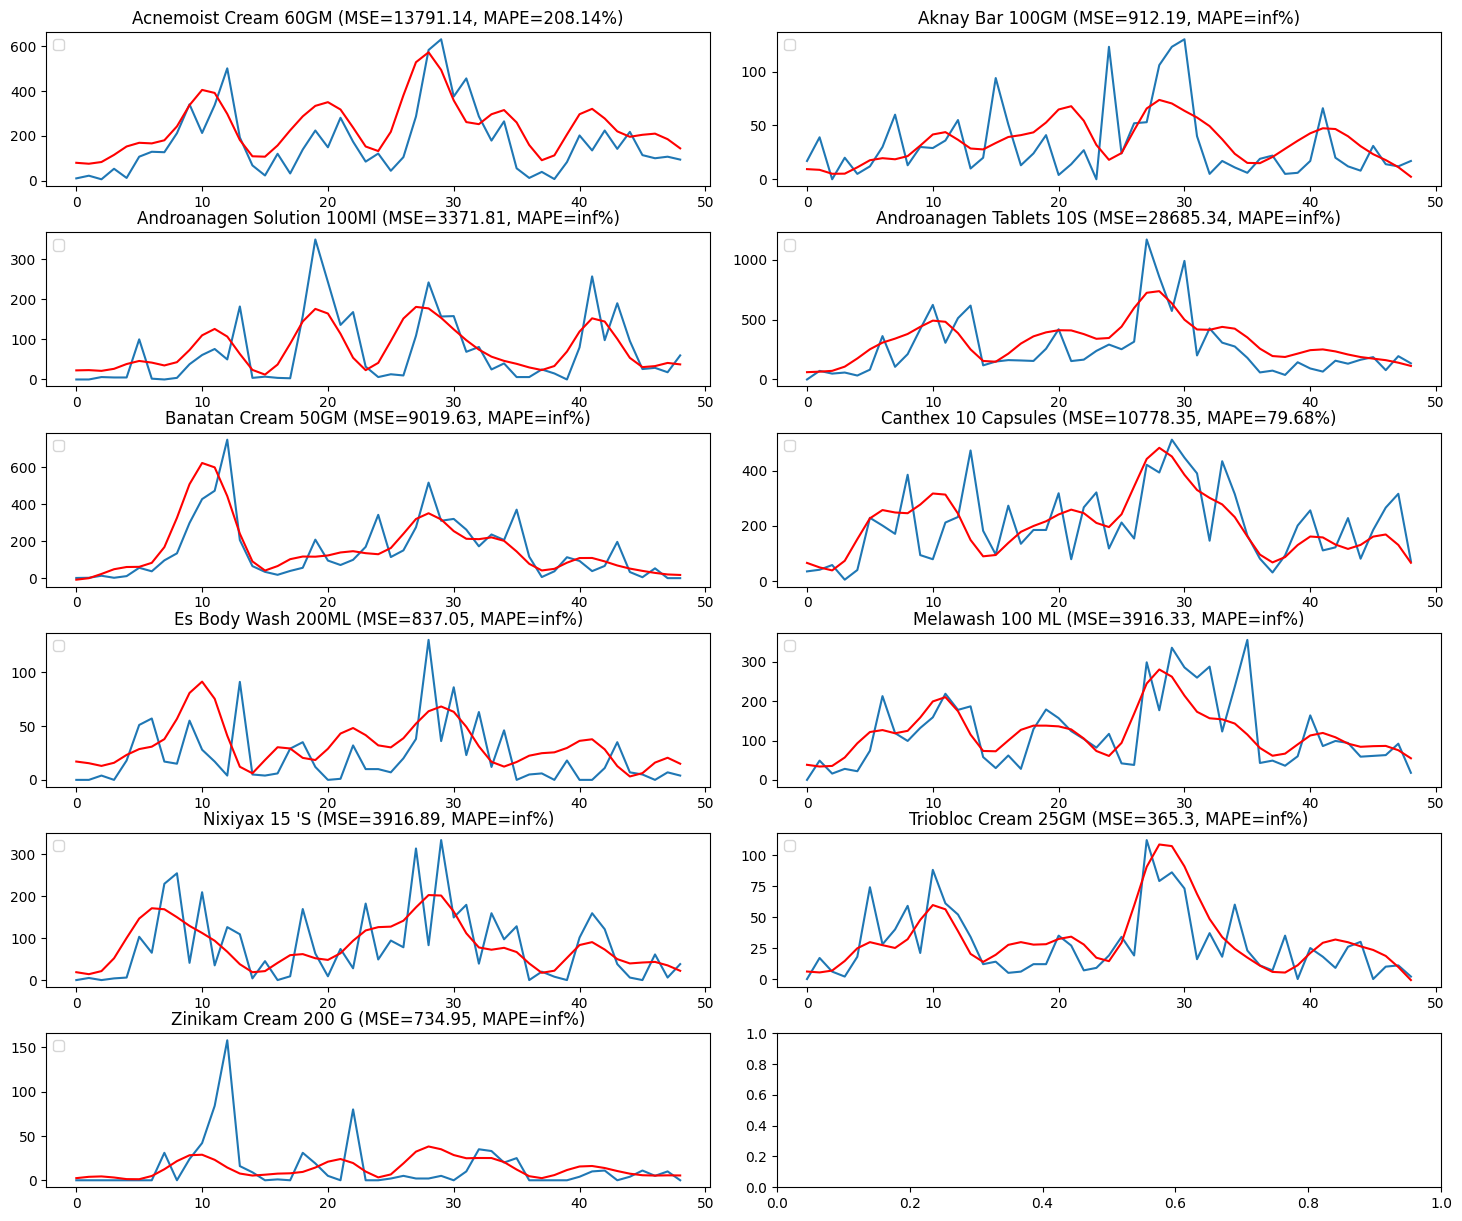

In [34]:
df = pd.read_csv('salesweekly.csv')

subplotindex=0
numrows=6
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

Acnemoist_Cream_60GM= {'series':'Acnemoist Cream 60GM','params_grid':{'changepoint_prior_scale': 50, 'interval_width': 0.0005}}
Aknay_Bar_100GM= {'series':'Aknay Bar 100GM','params_grid':{'changepoint_prior_scale': 0.01,  'interval_width': 0.0005}}
Androanagen_Solution_100Ml= {'series':'Androanagen Solution 100Ml','params_grid':{'changepoint_prior_scale': 0.01,  'interval_width': 0.0005}}
Androanagen_Tablets_10S= {'series':'Androanagen Tablets 10S','params_grid':{'changepoint_prior_scale': 5,  'interval_width': 0.0005, 'seasonality_prior_scale': 200}}
Banatan_Cream_50GM= {'series':'Banatan Cream 50GM','params_grid':{'changepoint_prior_scale': 5,  'interval_width': 0.0005}}
Canthex_10_Capsules= {'series':'Canthex 10 Capsules','params_grid':{'changepoint_prior_scale': 0.05,  'interval_width': 0.0005}}
Es_Body_Wash_200ML= {'series':'Es Body Wash 200ML','params_grid':{'changepoint_prior_scale': 0.1,  'interval_width': 0.0005, 'seasonality_prior_scale': 120}}
Melawash_100_ML= {'series':'Melawash 100 ML','params_grid':{'changepoint_prior_scale': 0.05,  'interval_width': 0.0005, 'seasonality_prior_scale': 200}}
Nixiyax_15_S= {'series':"Nixiyax 15 'S",'params_grid':{'changepoint_prior_scale': 0.05, 'interval_width': 0.0005, 'seasonality_prior_scale': 120}}
Triobloc_Cream_25GM= {'series':'Triobloc Cream 25GM','params_grid':{'changepoint_prior_scale': 0.01,  'interval_width': 0.0005, 'seasonality_prior_scale': 100}}
Zinikam_Cream_200_G= {'series':'Zinikam Cream 200 G','params_grid':{'changepoint_prior_scale': 0.1,  'interval_width': 0.0005, 'seasonality_prior_scale': 120}}


r=[Acnemoist_Cream_60GM,Aknay_Bar_100GM,Androanagen_Solution_100Ml,Androanagen_Tablets_10S,Banatan_Cream_50GM,Canthex_10_Capsules,Es_Body_Wash_200ML,Melawash_100_ML,Nixiyax_15_S,Triobloc_Cream_25GM,Zinikam_Cream_200_G]

for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    dfg=df[['datum',x['series']]]
    dfg = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
    size = int(len(dfg) - 50)
    dfgtrain=dfg.loc[0:size,:]
    dfgtest=dfg.loc[size+1:len(dfg),:]
    predictions = list()
    model = Prophet(changepoint_prior_scale=x['params_grid']['changepoint_prior_scale'],
                              growth='linear', interval_width=x['params_grid']['interval_width'],
                              daily_seasonality=False,
                              weekly_seasonality=False
                           )
    if(x=='Acnemoist Cream 60GM' or x=='Aknay Bar 100GM' or x=='Androanagen Solution 100Ml' or x=='Androanagen Tablets 10S'or x=='Banatan Cream 50GM'or x=='Canthex 10 Capsules' or x=='Es Body Wash 200ML' or x=='Melawash 100 ML' or x=="Nixiyax 15 'S" or x=='Triobloc Cream 25GM' or x == 'Zinikam Cream 200 G' ):
        model=model.add_seasonality(
                                name='yearly',
                                period=365.25,
                                prior_scale=x['params_grid']['seasonality_prior_scale'],
                                fourier_order=13)
    model_fit = model.fit(dfgtrain)
    future = model.make_future_dataframe(periods=50, freq='W')
    output = model.predict(future)
    predictions=output.loc[size+2:len(dfg),:]['yhat'].values

    error = mean_squared_error(dfgtest['y'].values, predictions)
    perror = mean_absolute_percentage_error(dfgtest['y'].values, predictions)
    resultsLongtermdf.loc['Prophet MSE',x['series']]=error
    resultsLongtermdf.loc['Prophet MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(dfgtest['y'].values)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

#### 4.3.3.3. Long-term forecasting with Prophet

10:19:00 - cmdstanpy - INFO - Chain [1] start processing
10:19:00 - cmdstanpy - INFO - Chain [1] done processing
10:19:00 - cmdstanpy - INFO - Chain [1] start processing
10:19:00 - cmdstanpy - INFO - Chain [1] done processing
10:19:00 - cmdstanpy - INFO - Chain [1] start processing
10:19:00 - cmdstanpy - INFO - Chain [1] done processing
10:19:00 - cmdstanpy - INFO - Chain [1] start processing
10:19:00 - cmdstanpy - INFO - Chain [1] done processing
10:19:01 - cmdstanpy - INFO - Chain [1] start processing
10:19:01 - cmdstanpy - INFO - Chain [1] done processing
10:19:01 - cmdstanpy - INFO - Chain [1] start processing
10:19:01 - cmdstanpy - INFO - Chain [1] done processing
10:19:01 - cmdstanpy - INFO - Chain [1] start processing
10:19:01 - cmdstanpy - INFO - Chain [1] done processing
10:19:01 - cmdstanpy - INFO - Chain [1] start processing
10:19:01 - cmdstanpy - INFO - Chain [1] done processing
10:19:01 - cmdstanpy - INFO - Chain [1] start processing
10:19:02 - cmdstanpy - INFO - Chain [1]

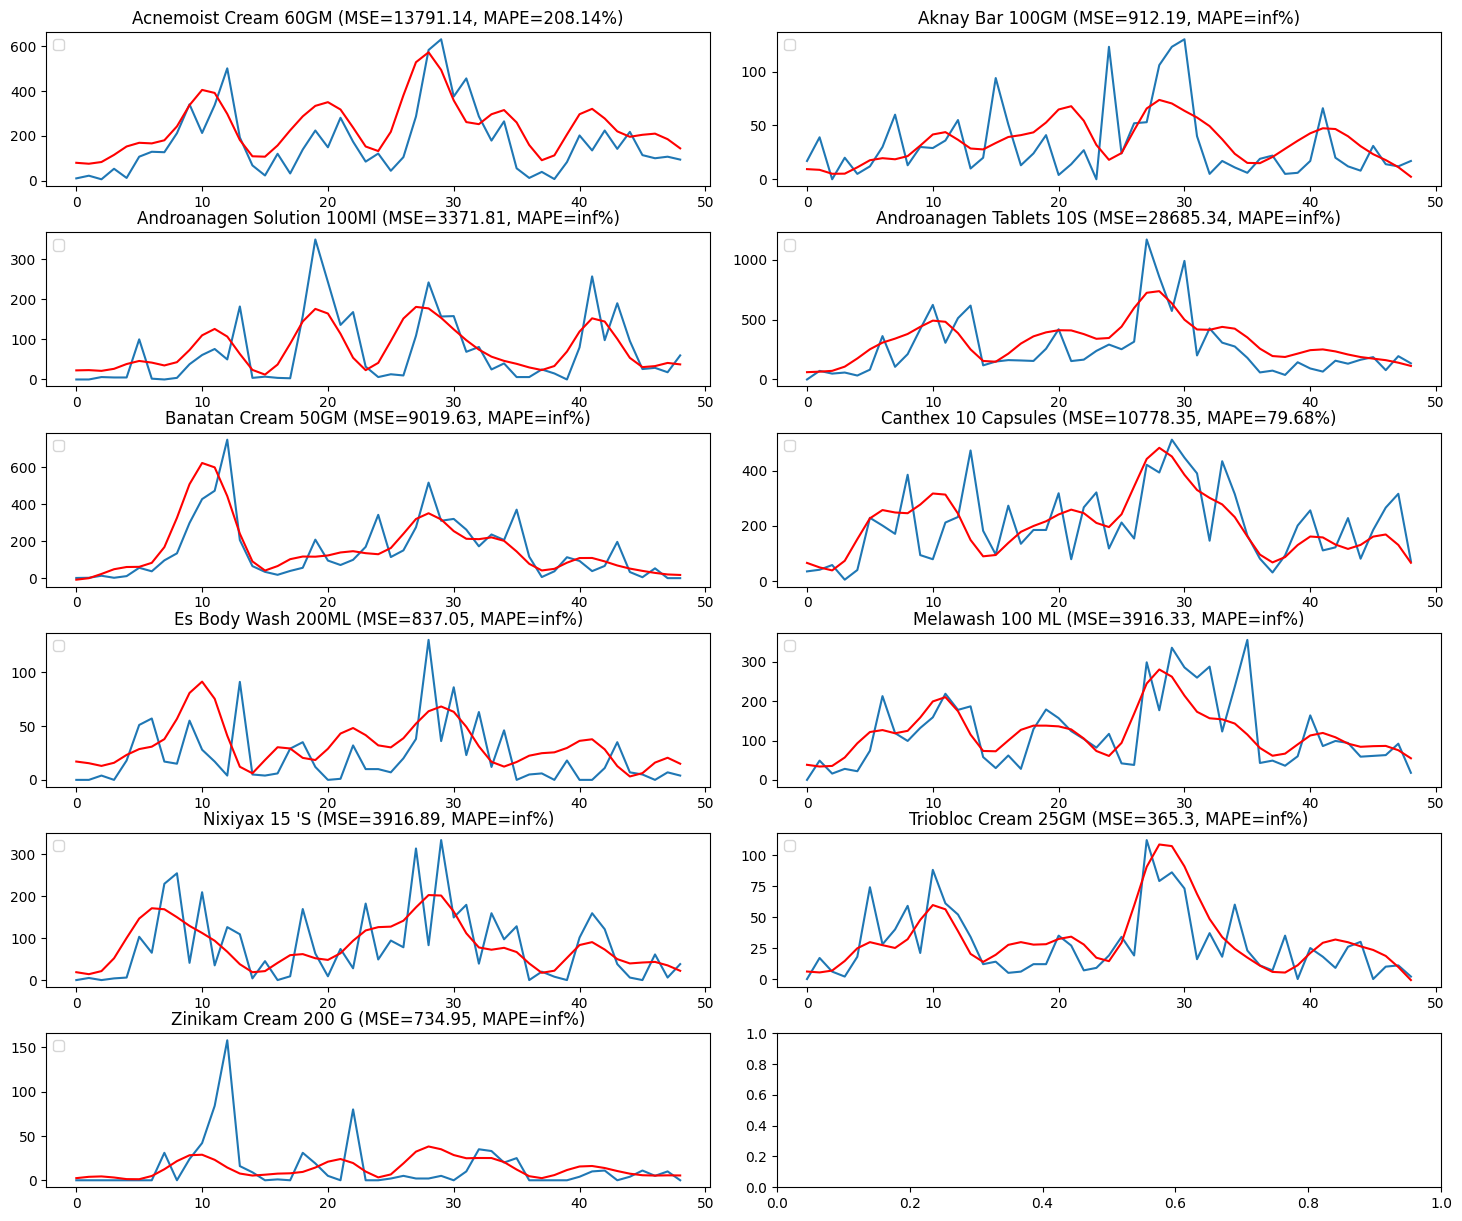

In [35]:
df = pd.read_csv('salesweekly.csv')

subplotindex=0
numrows=6
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

Acnemoist_Cream_60GM= {'series':'Acnemoist Cream 60GM','params_grid':{'changepoint_prior_scale': 50, 'interval_width': 0.0005}}
Aknay_Bar_100GM= {'series':'Aknay Bar 100GM','params_grid':{'changepoint_prior_scale': 0.01,  'interval_width': 0.0005}}
Androanagen_Solution_100Ml= {'series':'Androanagen Solution 100Ml','params_grid':{'changepoint_prior_scale': 0.01,  'interval_width': 0.0005}}
Androanagen_Tablets_10S= {'series':'Androanagen Tablets 10S','params_grid':{'changepoint_prior_scale': 5,  'interval_width': 0.0005, 'seasonality_prior_scale': 200}}
Banatan_Cream_50GM= {'series':'Banatan Cream 50GM','params_grid':{'changepoint_prior_scale': 5,  'interval_width': 0.0005}}
Canthex_10_Capsules= {'series':'Canthex 10 Capsules','params_grid':{'changepoint_prior_scale': 0.05,  'interval_width': 0.0005}}
Es_Body_Wash_200ML= {'series':'Es Body Wash 200ML','params_grid':{'changepoint_prior_scale': 0.1,  'interval_width': 0.0005, 'seasonality_prior_scale': 120}}
Melawash_100_ML= {'series':'Melawash 100 ML','params_grid':{'changepoint_prior_scale': 0.05,  'interval_width': 0.0005, 'seasonality_prior_scale': 200}}
Nixiyax_15_S= {'series':"Nixiyax 15 'S",'params_grid':{'changepoint_prior_scale': 0.05, 'interval_width': 0.0005, 'seasonality_prior_scale': 120}}
Triobloc_Cream_25GM= {'series':'Triobloc Cream 25GM','params_grid':{'changepoint_prior_scale': 0.01,  'interval_width': 0.0005, 'seasonality_prior_scale': 100}}
Zinikam_Cream_200_G= {'series':'Zinikam Cream 200 G','params_grid':{'changepoint_prior_scale': 0.1,  'interval_width': 0.0005, 'seasonality_prior_scale': 120}}

r=[Acnemoist_Cream_60GM,Aknay_Bar_100GM,Androanagen_Solution_100Ml,Androanagen_Tablets_10S,Banatan_Cream_50GM,Canthex_10_Capsules,Es_Body_Wash_200ML,Melawash_100_ML,Nixiyax_15_S,Triobloc_Cream_25GM,Zinikam_Cream_200_G]

for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    dfg=df[['datum',x['series']]]
    dfg = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
    size = int(len(dfg) - 50)
    dfgtrain=dfg.loc[0:size,:]
    dfgtest=dfg.loc[size+1:len(dfg),:]
    predictions = list()
    model = Prophet(changepoint_prior_scale=x['params_grid']['changepoint_prior_scale'],
                              growth='linear', interval_width=x['params_grid']['interval_width'],
                              daily_seasonality=False,
                              weekly_seasonality=False
                           )
    if(x=='Acnemoist Cream 60GM' or x=='Aknay Bar 100GM' or x=='Androanagen Solution 100Ml' or x=='Androanagen Tablets 10S'or x=='Banatan Cream 50GM'or x=='Canthex 10 Capsules' or x=='Es Body Wash 200ML' or x=='Melawash 100 ML' or x=="Nixiyax 15 'S" or x=='Triobloc Cream 25GM' or x == 'Zinikam Cream 200 G' ):
        model=model.add_seasonality(
                                name='yearly',
                                period=365.25,
                                prior_scale=x['params_grid']['seasonality_prior_scale'],
                                fourier_order=13)
    model_fit = model.fit(dfgtrain)
    future = model.make_future_dataframe(periods=50, freq='W')
    output = model.predict(future)
    predictions=output.loc[size+2:len(dfg),:]['yhat'].values

    error = mean_squared_error(dfgtest['y'].values, predictions)
    perror = mean_absolute_percentage_error(dfgtest['y'].values, predictions)
    resultsLongtermdf.loc['Prophet MSE',x['series']]=error
    resultsLongtermdf.loc['Prophet MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(dfgtest['y'].values)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

### 4.3.4. Forecasting with LSTM

Long-term forecasting validation has been done with three LSTM configurations: Vanilla LSTM, Stacked LSTM and Bi-directional LSTM. Relu activation function was used, optimizer was Adam and loss function was Mean Squared Error. The best results were achieved with training the model in 400 epochs. Before fitting, all data was standardized (rescaled in interval -1,1) and transformed to data for supervised problem.

Number of past observations tested in input sequences was either 10 or 5. For series with larger variances and randomness (N05B and N05C) and simpler, Vanilla LSTM model, 10 past observations produced better forecasting accuracy. In all other cases, 5 past observations were used. This is the parameter that has been adopted.

In order to get reproducible results in forecasting with LSTM, following values are fixed: seed value, 'PYTHONHASHSEED' environment variable, Python's, numpy's and Tensorflow's built-in pseudo-random generators. A new global Tensorflow session is configured.

In [36]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

Components required for forecasting with LSTM are then imported. Function split_sequence for transforming time-series data to data for supervised machine learning problem is provided, including constants, such as number of previous steps to take into account.

In [37]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

size = int(len(df) - 50)
n_steps=5
n_features = 1

#### 4.3.4.1. Long-term forecasting with Vanilla LSTM configuration

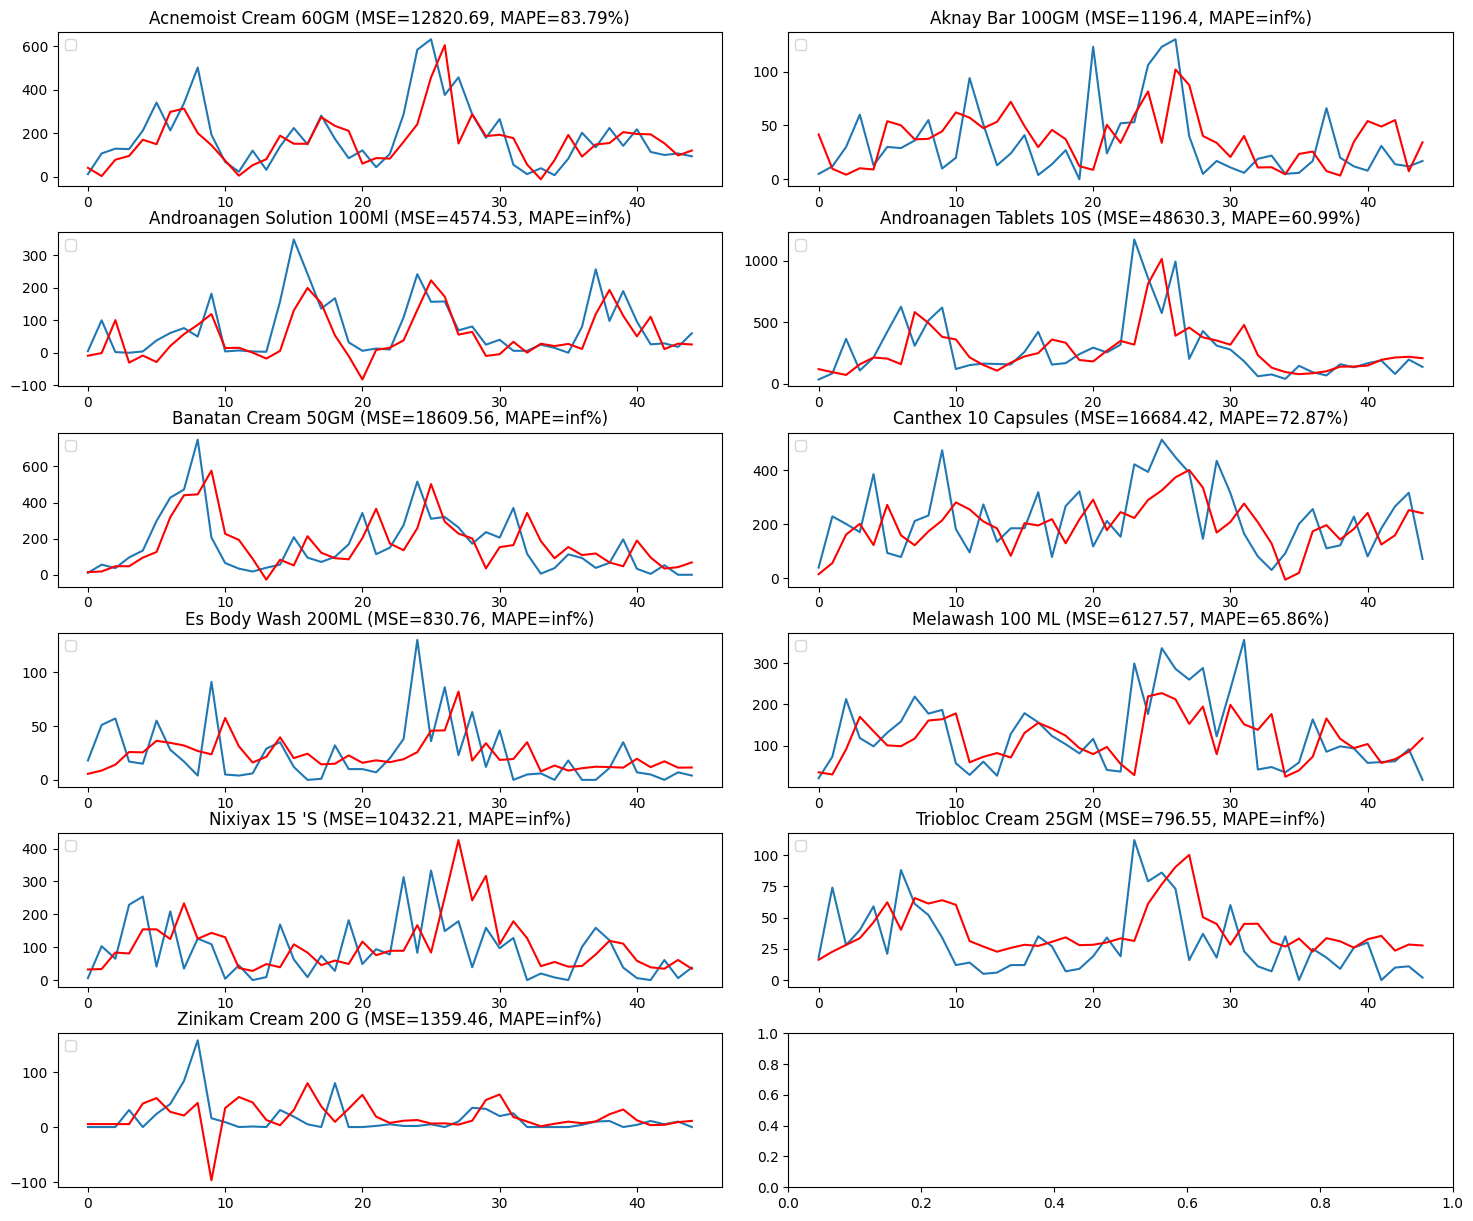

In [38]:
df = pd.read_csv('salesweekly.csv')

subplotindex=0
numrows=6
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

r=['Acnemoist Cream 60GM','Aknay Bar 100GM','Androanagen Solution 100Ml','Androanagen Tablets 10S','Banatan Cream 50GM','Canthex 10 Capsules','Es Body Wash 200ML','Melawash 100 ML',"Nixiyax 15 'S",'Triobloc Cream 25GM','Zinikam Cream 200 G']
for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)
    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Vanilla LSTM MSE',x]=error
    resultsLongtermdf.loc['Vanilla LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

#### 4.3.4.2. Long-term forecasting with Stacked LSTM model

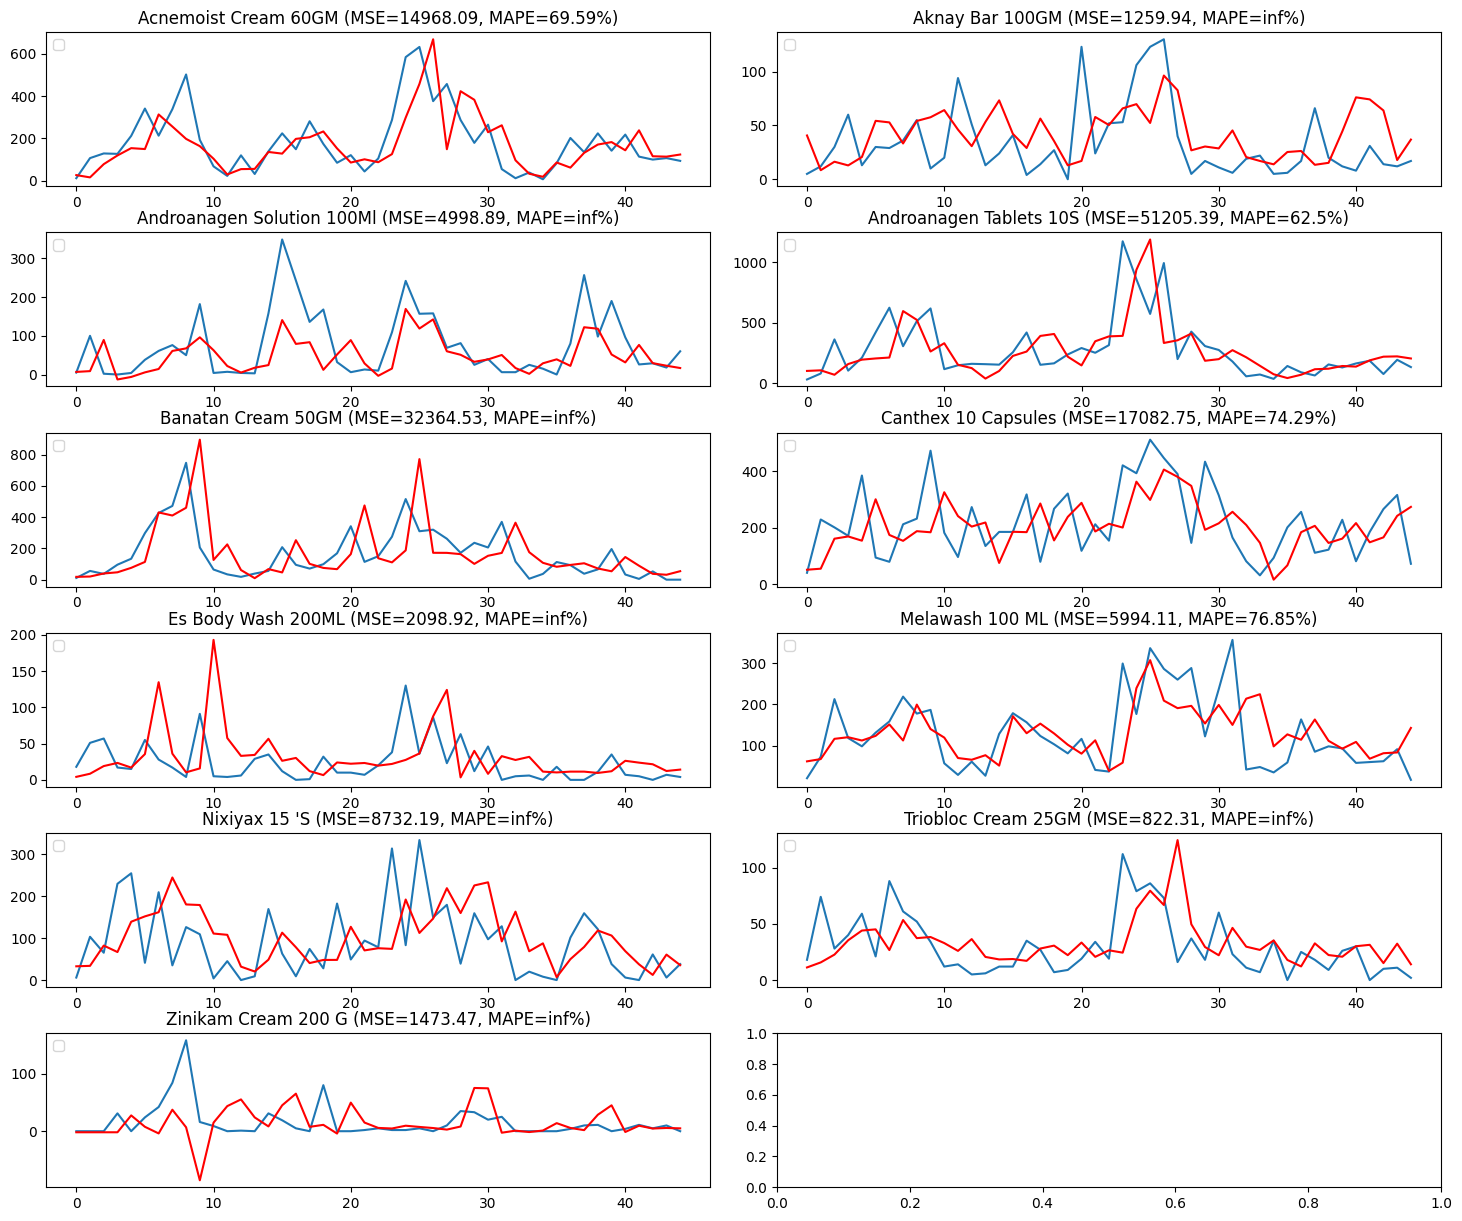

In [39]:
df = pd.read_csv('salesweekly.csv')

subplotindex=0
numrows=6
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

r=['Acnemoist Cream 60GM','Aknay Bar 100GM','Androanagen Solution 100Ml','Androanagen Tablets 10S','Banatan Cream 50GM','Canthex 10 Capsules','Es Body Wash 200ML','Melawash 100 ML',"Nixiyax 15 'S",'Triobloc Cream 25GM','Zinikam Cream 200 G']
for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)

    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Stacked LSTM MSE',x]=error
    resultsLongtermdf.loc['Stacked LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

#### 4.3.4.3. Long-term forecasting with Bidirectional LSTM

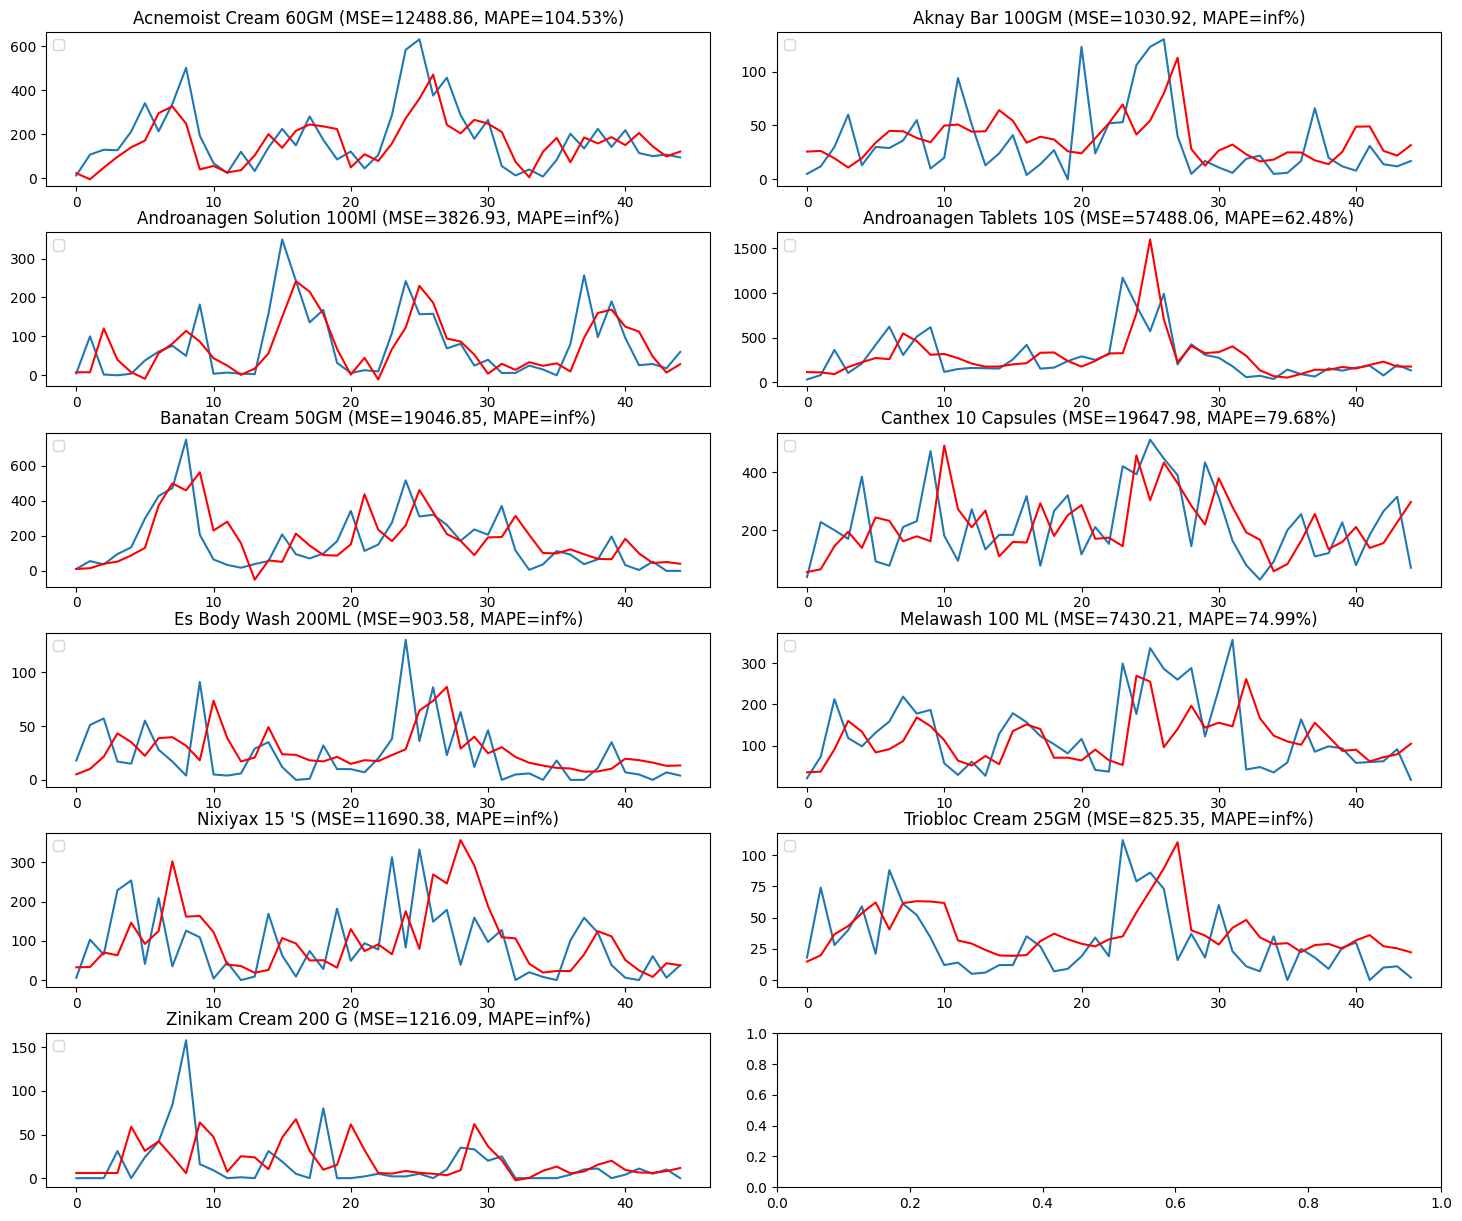

In [40]:
df = pd.read_csv('salesweekly.csv')

subplotindex=0
numrows=6
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

r=['Acnemoist Cream 60GM','Aknay Bar 100GM','Androanagen Solution 100Ml','Androanagen Tablets 10S','Banatan Cream 50GM','Canthex 10 Capsules','Es Body Wash 200ML','Melawash 100 ML',"Nixiyax 15 'S",'Triobloc Cream 25GM','Zinikam Cream 200 G']
for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)

    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Bidirectional LSTM MSE',x]=error
    resultsLongtermdf.loc['Bidirectional LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

# 5. Conclusion

For rolling forecast, ARIMA method (Auto-ARIMA for series with seasonal character) outperforms Prophet and is considered as a best candidate for short-term sales forecasting. All methods in all cases (with exception of Prophet) outperform reference benchmarks - Naive and Seasonal Naive forecasts.

In [41]:
from IPython.display import display, HTML
display(HTML(resultsRollingdf.to_html()))

For long-term forecasting, Prophet and LSTM models have shown significantly better performance then benchmarks in the time series with seasonality. In all cases, even without optimization, LSTM models have achieved competitive performance.

In [42]:
from IPython.display import display, HTML
display(HTML(resultsLongtermdf.to_html()))

To conclude, time-series analyses and forecasts have guided potentially useful conclusions and recommendations to the pharmacy. Daily, weekly and annual seasonality analysis were proven useful for identifying the periods in which special sales and marketing campaigns could be implemented, except for N05B and N05C categories of drugs which did not exhibit significant regularities. Forecasts have proven better than Naïve methods and in acceptable intervals for long-term planning. It is highly likely that the forecasts could be significantly improved by expanding the problem scope to multivariate time series forecasting and by including explanatory variables, such as:
- Weather data. Sales of antirheumatic drugs in M01AB and M01AE categories could be affected by the changes of atmospheric pressure. Sudden declines in all categories could be explained by extreme weather conditions, such as heavy rain, thunderstorms and blizzards.
- Price of the drugs. Sales spikes may be explained by the discounts, applied in a short term. Introducing this feature may facilitate what-if forecasting analysis of sales performance during marketing campaigns involving price reductions.
- Dates of the pension payoff. Sales spikes are visible at the dates of state pensions payoff.
- National holidays, as non-working days with seasonal patterns similar to Sundays are expected to disrupt daily sales.

Future work on univariate time series forecasting includes increasing the number of data, exploring different other accuracy metrics, optimization of hyper-parameters for LSTM models and testing other architectures, such as CNN LSTM and ConvLSTM. However, key improvements in sales forecasting are expected from reducing the uncertainty of the models by expanding to multivariate time series forecasting problem, as explained above.